# Modulacion de palabras para clasificación

In [1]:
#Importamos algunas librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from nltk.tokenize import word_tokenize
import we_to_signal as wes

[nltk_data] Downloading package punkt to /home/ulises/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ulises/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Modulacion

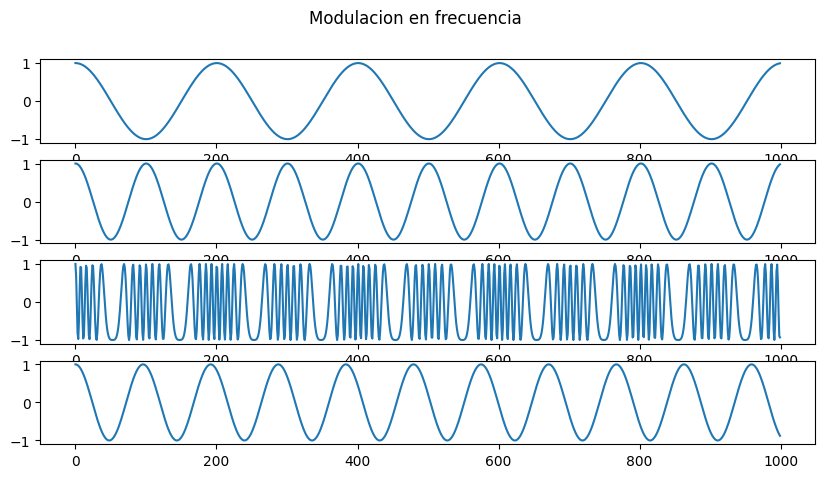

In [35]:
# Samples per second
sps = 44100

# Duration
duration_s = 5.0

# ac: amplitude of the carrier. Should be kept at 1.0 in this script
# you would modify it if you were micing it with, or modulating other,
# waveforms.

# carrier_hz: Frequency of the carrier
# fm_hz: Frequency of the frequency modulator
# k_p: deviation constant
carrier_amplitude = 1.0
carrier_hz = 440.0
fm_hz = 220.0
k = 25.0

# Our final waveform is going to be calculated as the cosine of carrier and
# frequency modulated terms.

# First, define our range of sample numbers
each_sample_number = np.arange(duration_s * sps)

# Create the term that create the carrier
carrier = 2 * np.pi * each_sample_number * carrier_hz / sps

# Now create the term that is the frequency modulator
modulator = k * np.sin(2 * np.pi * each_sample_number * fm_hz / sps)

# Now create the modulated waveform, and attenuate it
waveform = np.cos(carrier + modulator)
waveform_quiet = waveform * 0.3

fig,ax = plt.subplots(4,figsize=(10,5))

fig.suptitle("Modulacion en frecuencia")
ax[0].plot(np.cos(2 * np.pi * each_sample_number * fm_hz / sps)[:1000])
ax[1].plot(np.cos(carrier[:1000]))
ax[2].plot(waveform[:1000])
ax[3].plot(np.cos(2*np.pi*460*each_sample_number/sps)[:1000])

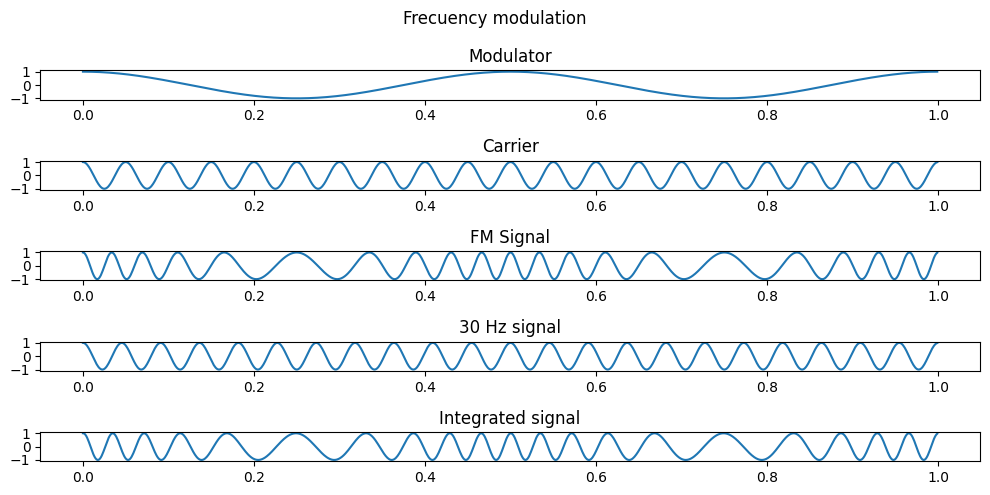

In [63]:
from scipy.integrate import simpson

dt = 0.001
t = np.arange(0,1,dt)

f_carrier = 20
carrier = np.cos(2*np.pi*f_carrier*t)

f_moduladora = 2
moduladora = np.cos(2*np.pi*f_moduladora*t)

k = 10
sig_modulada = np.cos(2*np.pi*f_carrier*t + (k/f_moduladora)*np.sin(2*np.pi*f_moduladora*t))

integral = [simpson(y=moduladora[:i],dx=dt) for i in range(1,len(moduladora))]
integral.insert(0,0)
integral = np.array(integral)

k_int = 58
sig_modulada_integrada = np.cos(2*np.pi*f_carrier*t + k_int*integral)

fig,ax = plt.subplots(5,figsize=(10,5))

fig.suptitle("Frecuency modulation")

ax[0].set_title("Modulator")
ax[0].plot(t,moduladora)

ax[1].set_title("Carrier")
ax[1].plot(t,carrier)

ax[2].set_title("FM Signal")
ax[2].plot(t,sig_modulada)

ax[3].set_title("30 Hz signal")
ax[3].plot(t,np.cos(2*np.pi*22*t))

ax[4].set_title("Integrated signal")
ax[4].plot(t,sig_modulada_integrada)

fig.tight_layout()

## Carga de corpus y calculo de embbeddings

In [65]:
#Con los poemas separados, los metemos en un diccionario de dataframes
import os

data_path = "data/"
emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

json_files = sorted([pos_json for pos_json in os.listdir(data_path) if pos_json.endswith('.json')])
json_files.remove('Poems.json')
json_files.remove('missing.json')

em_poems = {}
for e in emotion_list:
    f = open(data_path+e+".json")
    df_ = pd.DataFrame(json.load(f))
    em_poems[e] = df_
em_poems["anger"]

,poem,id
0,i do know this it's nothing i can hold\nlast ...,10
1,the fear o' hell's a hangman's whip\nto haud t...,18
2,but since i laid a hand thereon\nand found a h...,88
3,falsely i pointed to sum in text\nseriously he...,99
4,i'll wear my jealous reflection\njuice of lemo...,125
...,...,...
2461,new snow on a leaf\nlike granulated sugar\nmak...,93124
2462,new earth and old earth\na trio of guardians\n...,93138
2463,destructions despair\nconstructions hope toge...,93217
2464,hot dry summers will\nbake paint right off the...,93226


In [66]:
#Carga de embeddings
from gensim.models import Word2Vec
from gensim.models import FastText

emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

poems_w2v = {}
poems_fst = {}

for e in emotion_list:
    w2v_lines = Word2Vec.load("embeddings_poems/w2v_model_"+e)
    fst_lines = FastText.load("embeddings_poems/fst_model_"+e)
    poems_w2v[e] = w2v_lines
    poems_fst[e] = fst_lines

## Simulitud de palabras entre emociones

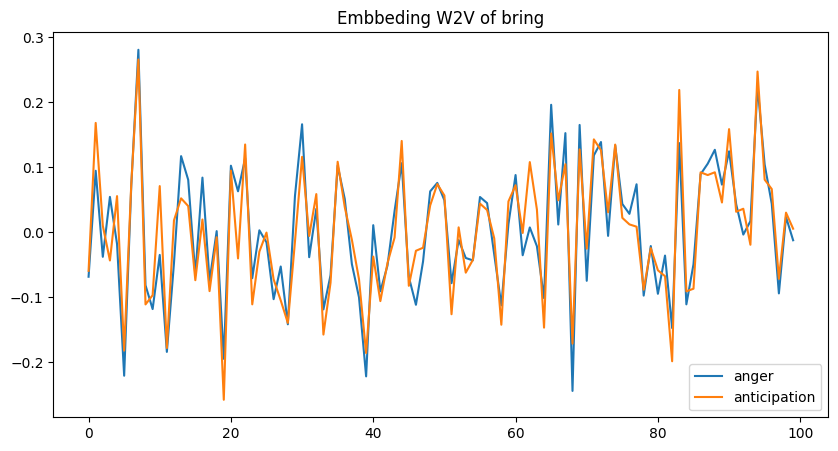

In [5]:
#Parametros
word = "bring"
emotion_a = "anger"
emotion_b = "anticipation"

#Extraccion del embbeding
embbeding_emotion_a = poems_w2v[emotion_a].wv.get_vector(word,norm=True)
embbeding_emotion_b = poems_w2v[emotion_b].wv.get_vector(word,norm=True)

plt.figure(figsize=(10,5))
plt.title("Embbeding W2V of "+word)
plt.plot(embbeding_emotion_a)
plt.plot(embbeding_emotion_b)
plt.legend([emotion_a,emotion_b])

PearsonRResult(statistic=0.9157850532955004, pvalue=1.323292927356247e-40)

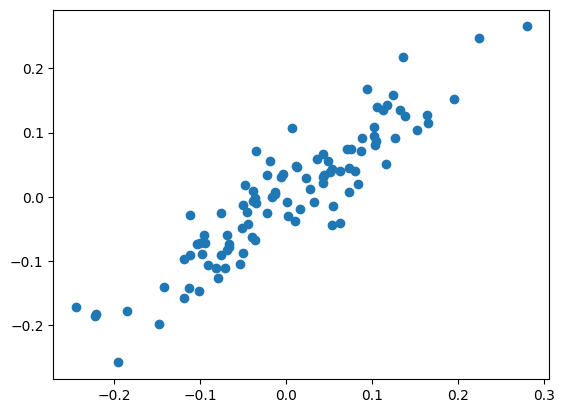

In [6]:
#Scatter plot para observar su correlación y correlacion pearson
from scipy.stats import pearsonr

plt.scatter(embbeding_emotion_a,embbeding_emotion_b)
display(pearsonr(embbeding_emotion_a,embbeding_emotion_b))

In [7]:
#Calculamos la interseccion entre palabras de fst,w2v y todas las emociones

words_intersection = set()
for emotion in emotion_list:
    fst = set(poems_fst[emotion].wv.key_to_index.keys())
    w2v = set(poems_w2v[emotion].wv.key_to_index.keys())
    intersection = fst & w2v
    if not words_intersection:
        words_intersection = words_intersection.union(intersection)
    else:
        words_intersection = words_intersection.intersection(intersection)

display(len(words_intersection))

677

In [8]:
#Eliminamos las stopwords de la interseccion
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words_intersection = words_intersection - stop_words
len(words_intersection)

562

In [9]:
#Funciones de procesamiento y obtencion de frecuencia de las palabras
from collections import Counter

def get_word_freq(dataframe:pd.DataFrame,col:str,emotion_list:list):
    """
    Calculates for Counter model of each emotion text corpus.

    Parameters
    ------------
    dataframe: pandas Dataframe with documents.
    col:str name of the column where the documents are.
    emotion_list: list with emotions

    Returns
    -----------
    dict:
        dictionary with keys(emotions_list) an each key with his self Counter model.
    """
    freq_dict = {}
    for emotion in emotion_list:
        tokens = dataframe[emotion][col].apply(lambda x: [token for token in word_tokenize(x)])
        l1 = tokens.values.tolist()
        l2 = [w for l in l1 for w in l ]
        freq_dict[emotion] = Counter(l2)
    return freq_dict

def text_clean(sent):
    """
    Clean the text of some chars
    
    Parameters
    -------------
    sent: str
        Sentence to be cleaned
    
    Returns
    -------------
    str:
        Sentence cleaned.
    """
    import re
    from unidecode import unidecode
    import unicodedata as ud

    d = {ord('\N{combining acute accent}'):None}
    sent = ud.normalize('NFD',sent).translate(d)
    sent = re.sub(r"[^\w .,;?!\n]+", "", sent)
    sent = re.sub(r"[^\w .,;?!]", " ", sent)
    sent = re.sub(r"[^\w .,]", ".", sent)
    sent = re.sub(r"[^\w ]", "", sent)
    sent = re.sub(r"[0-9]", "", sent)
    sent = re.sub(r"[α-ωςϑϕϜϝϞϠϰϱ]", "", sent)
    sent = re.sub(r"[ΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩ]", "", sent)
    sent = re.sub(r"[A-Z]{2}", "", sent)
    return sent

In [10]:
#Creamos una copia de los poemas y calculamos la frecuencia de aparición de las palabras
em_poem_c = dict()

for emotion in emotion_list:
    em_poem_c[emotion] = em_poems[emotion].copy()

for emotion in emotion_list:
    em_poem_c[emotion]["poems_clean"] = em_poem_c[emotion]["poem"].apply(text_clean)

freq_dict = get_word_freq(em_poem_c,"poems_clean",emotion_list)

In [11]:
#Creamos el dataframe de las palabras con su correlacion pearson
from itertools import combinations

def create_correlation_df(models,emotion_list,words_intersection,freq_dict):
    """
    Crea un dataset con informacion de la correlacion de las palabras
    entre emociones añadiendo su frecuencia de aparicion en el corpus.
    """
    emotion_combinations = list(combinations(emotion_list,2))

    words_embbed_info = {}
    words_embbed_info["words"] = list(words_intersection)

    for emotion in emotion_list:
        words_embbed_info["f_"+emotion] = []

    for comb in emotion_combinations:
        words_embbed_info["P_"+str(comb)] = []

    for word in words_intersection:
        #Añadimos la frecuencia por cada emoción
        for emotion in emotion_list:
            words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

        #Calculamos la correlacion pearson para cada par de emociones.    
        for comb in emotion_combinations:
            emotion_a = comb[0]
            emotion_b = comb[1]

            words_embbed_info["P_"+str(comb)].append(pearsonr(models[emotion_a].wv.get_vector(word,norm=True),models[emotion_b].wv.get_vector(word,norm=True)))

    return pd.DataFrame(words_embbed_info)

In [12]:
words_embbed_w2v_info = create_correlation_df(poems_w2v,emotion_list,words_intersection,freq_dict)
words_embbed_fst_info = create_correlation_df(poems_fst,emotion_list,words_intersection,freq_dict)

display(words_embbed_w2v_info)
display(words_embbed_fst_info)

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,shadow,6,80,5,66,102,94,12,71,"(0.8733018594526265, 2.2710965123583628e-32)",...,"(0.8289580612993593, 1.7978047990873865e-26)","(0.8735012864760033, 2.112914119428143e-32)","(0.8890027793127355, 5.138798378808423e-35)","(0.8767807537240859, 6.332037957582143e-33)","(0.8713512525758462, 4.572378300173873e-32)","(0.878961413242481, 2.787555485856625e-33)","(0.8683923698099449, 1.2936198658840685e-31)","(0.9012189682784398, 2.2959865278166512e-37)","(0.8875228699903814, 9.478566452264143e-35)","(0.8754998600779911, 1.0179036576493848e-32)"
1,lake,12,31,10,27,33,63,9,47,"(0.8844124191843739, 3.3391238346533848e-34)",...,"(0.8204714762536045, 1.5510334757458235e-25)","(0.8609326369048775, 1.5980269069622133e-30)","(0.8891719069643113, 4.788905773777078e-35)","(0.8565278483445624, 6.590214121865215e-30)","(0.8569764390327191, 5.717133790285184e-30)","(0.8725585596388292, 2.969145347853416e-32)","(0.8439086812037626, 2.9783472849206777e-28)","(0.8789361793786098, 2.814400601952407e-33)","(0.8785995652005961, 3.1975896285172763e-33)","(0.8457668331348462, 1.7363316740411177e-28)"
2,golden,16,147,9,51,160,95,10,117,"(0.8737539486840563, 1.927889864109115e-32)",...,"(0.7938463918640267, 6.820293814144808e-23)","(0.8678503442692513, 1.560844838950234e-31)","(0.8784671911759571, 3.3618497000112085e-33)","(0.8441599956477697, 2.7698718414583808e-28)","(0.8563096670265565, 7.060625852448041e-30)","(0.8623925868078948, 9.884852151538078e-31)","(0.8285881752939521, 1.979688650973138e-26)","(0.8899420700853848, 3.4685329898926297e-35)","(0.8775792448584282, 4.697416895819444e-33)","(0.841687903811877, 5.6243836370724095e-28)"
3,well,62,204,54,133,255,208,24,359,"(0.9019719946314296, 1.607667436037609e-37)",...,"(0.8683562590302482, 1.3099391982633187e-31)","(0.8514175256983516, 3.217876640448934e-29)","(0.8773680723142608, 5.0844495113657596e-33)","(0.8365993727959693, 2.3280802872648512e-27)","(0.84776581639543, 9.639529955925881e-29)","(0.8442198342357777, 2.7223722864486453e-28)","(0.822618811648415, 9.089423324682855e-26)","(0.8499934993364159, 4.953185589157259e-29)","(0.8436619196843187, 3.197908405399e-28)","(0.855454008402874, 9.242743859983926e-30)"
4,young,20,208,6,32,330,58,38,42,"(0.9124468093492645, 8.191212370639467e-40)",...,"(0.8628688121615444, 8.441187493433495e-31)","(0.8888866968708232, 5.393278603131942e-35)","(0.8906833608048836, 2.536997579025135e-35)","(0.892474576275927, 1.180429962908886e-35)","(0.8753076024625056, 1.092583640779501e-32)","(0.8818145844055582, 9.300438214872585e-34)","(0.8927701205756078, 1.0390851963274853e-35)","(0.9012866909149513, 2.223826965360651e-37)","(0.900855097066912, 2.7246586399673033e-37)","(0.8930339542270957, 9.26975290804016e-36)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,heat,23,31,12,35,43,39,11,37,"(0.90103922747048, 2.4987818516134806e-37)",...,"(0.8504819286608343, 4.274213900979329e-29)","(0.8847293884642881, 2.941871807767547e-34)","(0.8906302144787861, 2.5947199687159713e-35)","(0.8690534745279781, 1.0276514940955996e-31)","(0.8854130659787195, 2.235750358929401e-34)","(0.8854545585422035, 2.1986931802979057e-34)","(0.8703573057541953, 6.502807709867855e-32)","(0.8940444994997608, 5.969621931401379e-36)","(0.8905978742173178, 2.630470728336011e-35)","(0.8690218618302129, 1.0390540600910382e-31)"
558,brought,18,73,8,41,53,40,8,68,"(0.9124070555018351, 8.3672850217187e-40)",...,"(0.8698635243197959, 7.737858197917985e-32)","(0.8885209596797465, 6.278230673140853e-35)","(0.8928202784582103, 1.0167983011995683e-35)","(0.873728283453148, 1.9459377126293378e-32)","(0.8912175838187588

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,shadow,6,80,5,66,102,94,12,71,"(0.860101853606292, 2.0952704678914237e-30)",...,"(0.8550725718358418, 1.0415888262472302e-29)","(0.8522677939741996, 2.481936823622915e-29)","(0.8745076985876465, 1.4650108561943291e-32)","(0.8687545184125576, 1.1405543533578523e-31)","(0.8586101516694105, 3.393191914383944e-30)","(0.7999957505752143, 1.8152883475044324e-23)","(0.8334174017284475, 5.5223648323285184e-27)","(0.8271519759944566, 2.87188266505284e-26)","(0.8803216737598007, 1.6575275442029613e-33)","(0.8583223214229421, 3.721613925854259e-30)"
1,lake,12,31,10,27,33,63,9,47,"(0.8827633548109683, 6.41578707669786e-34)",...,"(0.8868304476691692, 1.2585438256532276e-34)","(0.8582509743468422, 3.8077048002348454e-30)","(0.8760081975495362, 8.436488306751252e-33)","(0.8693233197349667, 9.351650338131233e-32)","(0.8503350249693428, 4.46825402895812e-29)","(0.8409146030275918, 7.00197300197147e-28)","(0.8600110518305109, 2.158010736635337e-30)","(0.8446768585776363, 2.3848884809341936e-28)","(0.8852575575643282, 2.380142440370674e-34)","(0.8603755510147079, 1.9167376245069052e-30)"
2,golden,16,147,9,51,160,95,10,117,"(0.8473550588807444, 1.0886063157589836e-28)",...,"(0.7653191918378335, 1.84542379878634e-20)","(0.818909560936332, 2.2777172893684313e-25)","(0.8740918976901538, 1.7049602688196497e-32)","(0.8129518554212293, 9.541074481000347e-25)","(0.8416023277031649, 5.762741324018321e-28)","(0.7170857586465095, 4.803179440854089e-17)","(0.8261208449712263, 3.7432787663905596e-26)","(0.7941301248963953, 6.422579911291683e-23)","(0.8845954461867879, 3.103762995858519e-34)","(0.792050825770134, 9.953855359697416e-23)"
3,well,62,204,54,133,255,208,24,359,"(0.8233515249257117, 7.561855695082096e-26)",...,"(0.8059534942975868, 4.81507774815595e-24)","(0.8981473017657147, 9.542382454989566e-37)","(0.8680939345650672, 1.4346760730995681e-31)","(0.8044619083876292, 6.741429746537987e-24)","(0.8040571679991653, 7.38231660397294e-24)","(0.6937812215120616, 1.2274437170758703e-15)","(0.7989666293773735, 2.272662823883323e-23)","(0.8662487654655987, 2.70546993638339e-31)","(0.8417716215896217, 5.492168830127826e-28)","(0.7590443623679364, 5.692366394432377e-20)"
4,young,20,208,6,32,330,58,38,42,"(0.883956134295933, 4.004398198602558e-34)",...,"(0.8675475770361067, 1.7328353171624723e-31)","(0.8928584904913439, 1.000133497001381e-35)","(0.8732676027618586, 2.2994081420664858e-32)","(0.8619889562657959, 1.1294942734850375e-30)","(0.8348341709897157, 3.767768258197806e-27)","(0.8155222956606796, 5.175480427401172e-25)","(0.8234944167351772, 7.294608984886713e-26)","(0.8855188811609336, 2.142429486099563e-34)","(0.8626717958531717, 9.011581401479113e-31)","(0.8533622834787902, 1.7724497009415947e-29)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,heat,23,31,12,35,43,39,11,37,"(0.8791387326738939, 2.6058414820647214e-33)",...,"(0.8733863745793956, 2.202696535495942e-32)","(0.8881276673368191, 7.388166582237474e-35)","(0.8720672818530781, 3.5413004224371357e-32)","(0.8549155136449473, 1.0940101300937156e-29)","(0.8555648333868944, 8.92678348324128e-30)","(0.8367027459756745, 2.262958029235497e-27)","(0.8481213420775595, 8.673946178210278e-29)","(0.871328150341486, 4.610115119130781e-32)","(0.883613864785884, 4.586787377596256e-34)","(0.8439426692864815, 2.949282469748299e-28)"
558,brought,18,73,8,41,53,40,8,68,"(0.8719402921482154, 3.7059016165391513e-32)",...,"(0.8855809639067082, 2.089460120017426e-34)","(0.8757211736433552, 9.380988557179536e-33)","(0.8735251416572362, 2.0947287865947838e-32)","(0.8607688415494431, 1.6859356971805655e-30)","(0.863793753230814

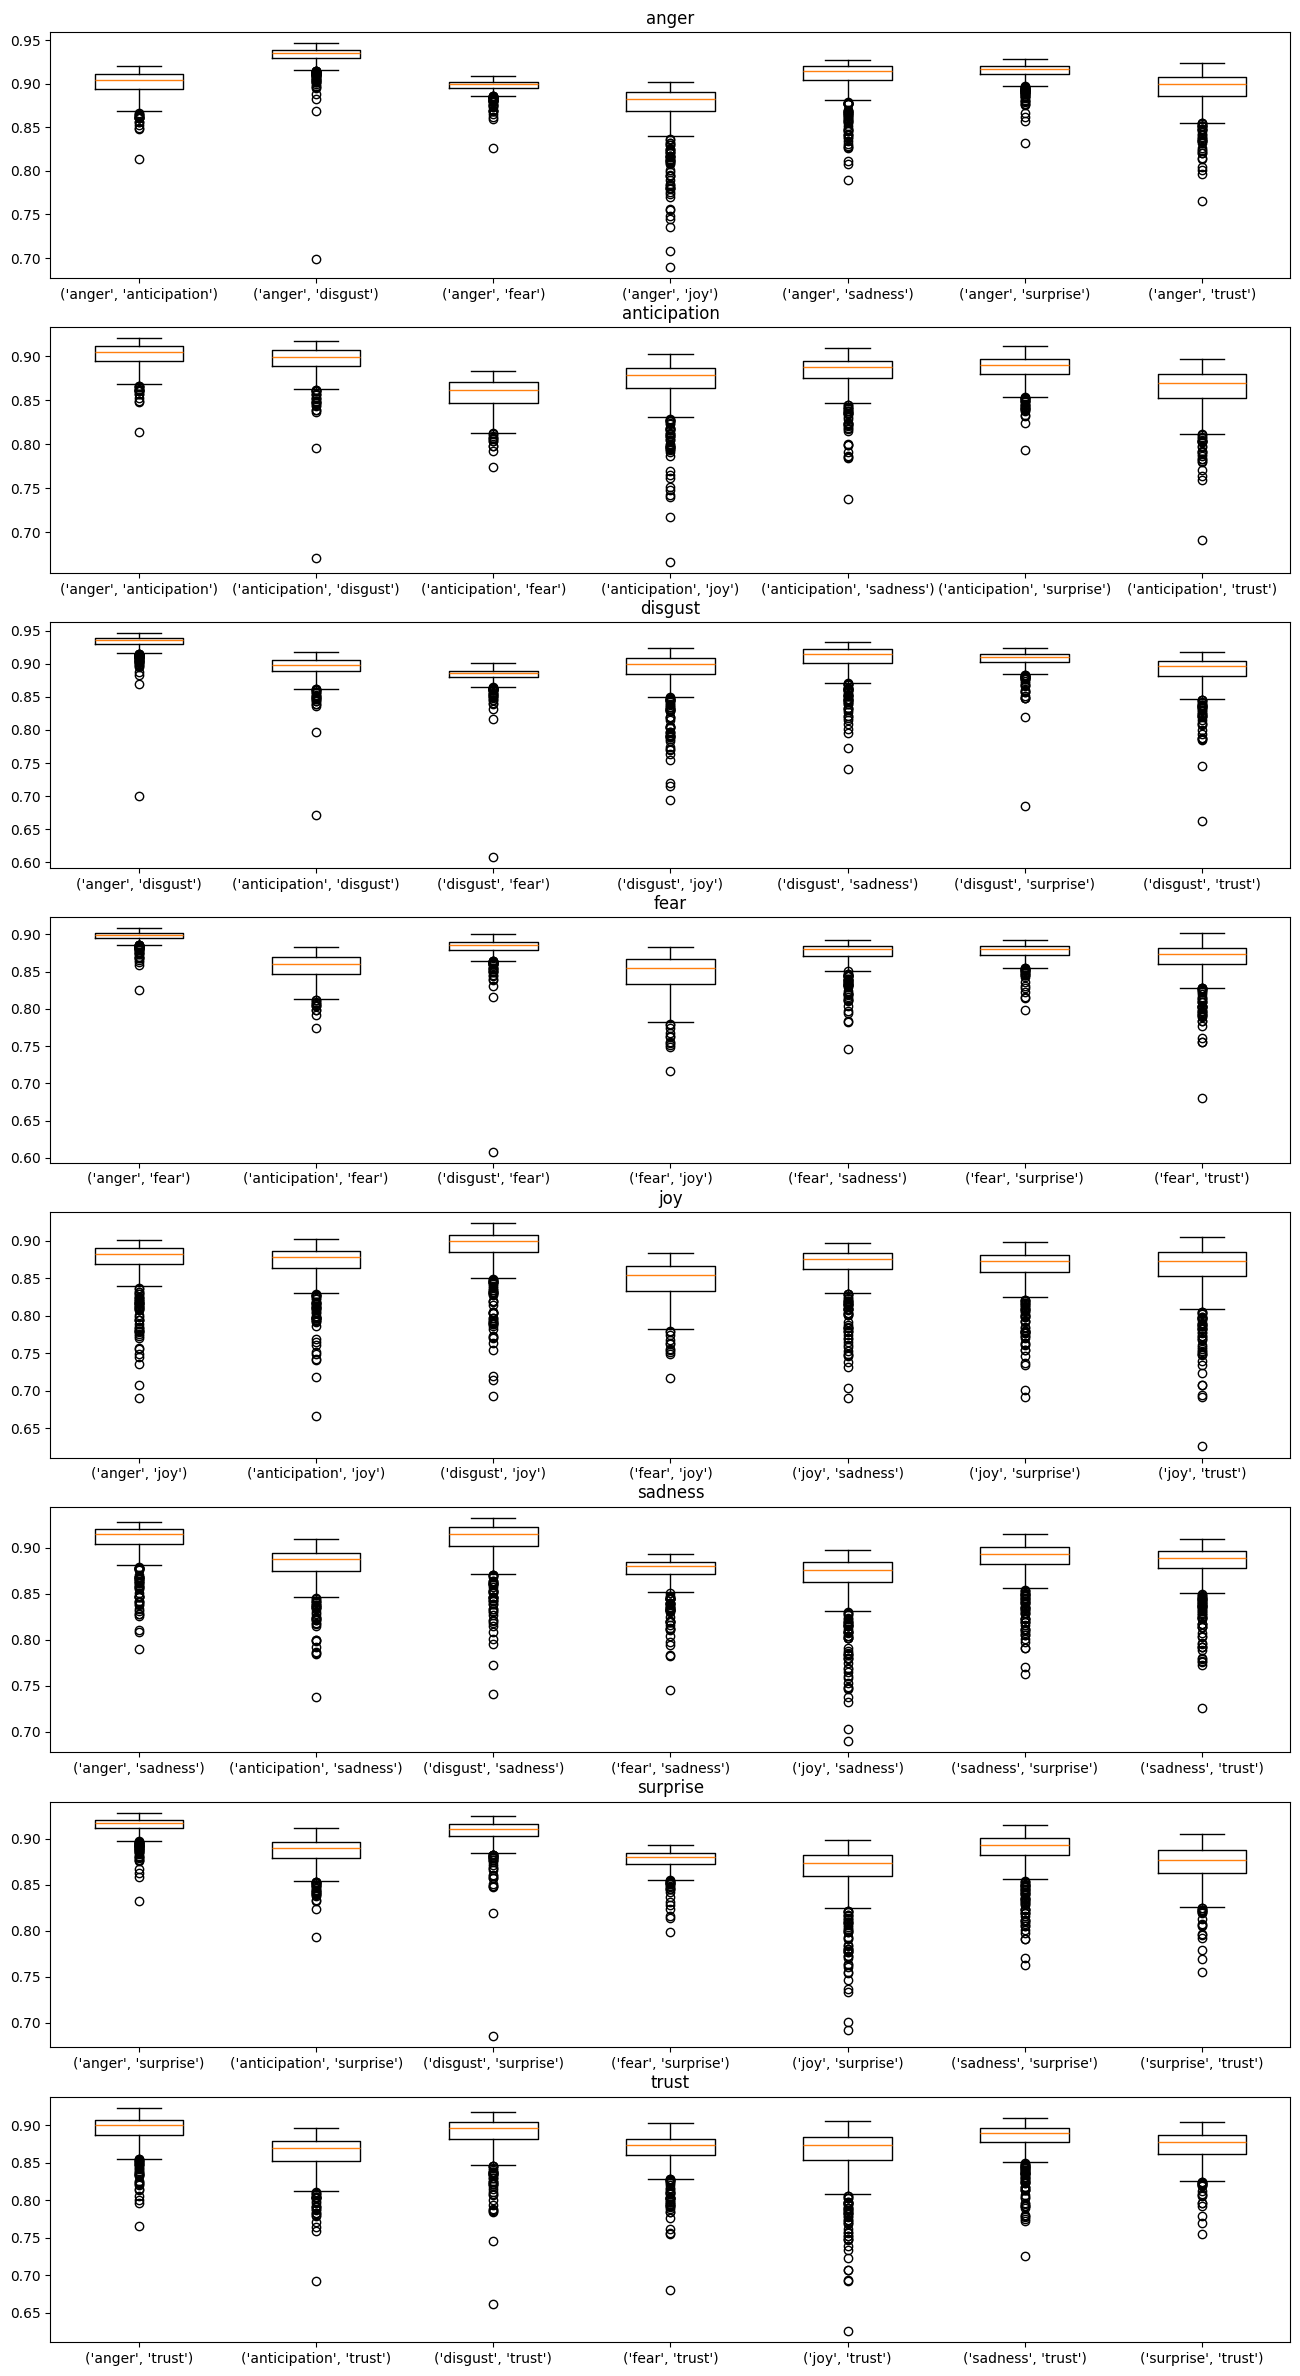

In [13]:
# Boxplots correlacion 
#sent = re.sub(r"[^\w .,;?!\n]+", "", sent)
import re
fig,ax = plt.subplots(8,figsize=(16,30))
columns = words_embbed_w2v_info.columns
i = 0
for emotion in emotion_list:
    data = []
    labels = []
    for column in columns:
        if emotion in column:
            if 'f_' in column:
                continue
            data.append([element[0] for element in words_embbed_w2v_info[column]])
            labels.append(re.sub(r"P_","",column))
    ax[i].boxplot(data)
    ax[i].set_xticklabels(labels)
    ax[i].set_title(emotion)
    i+=1

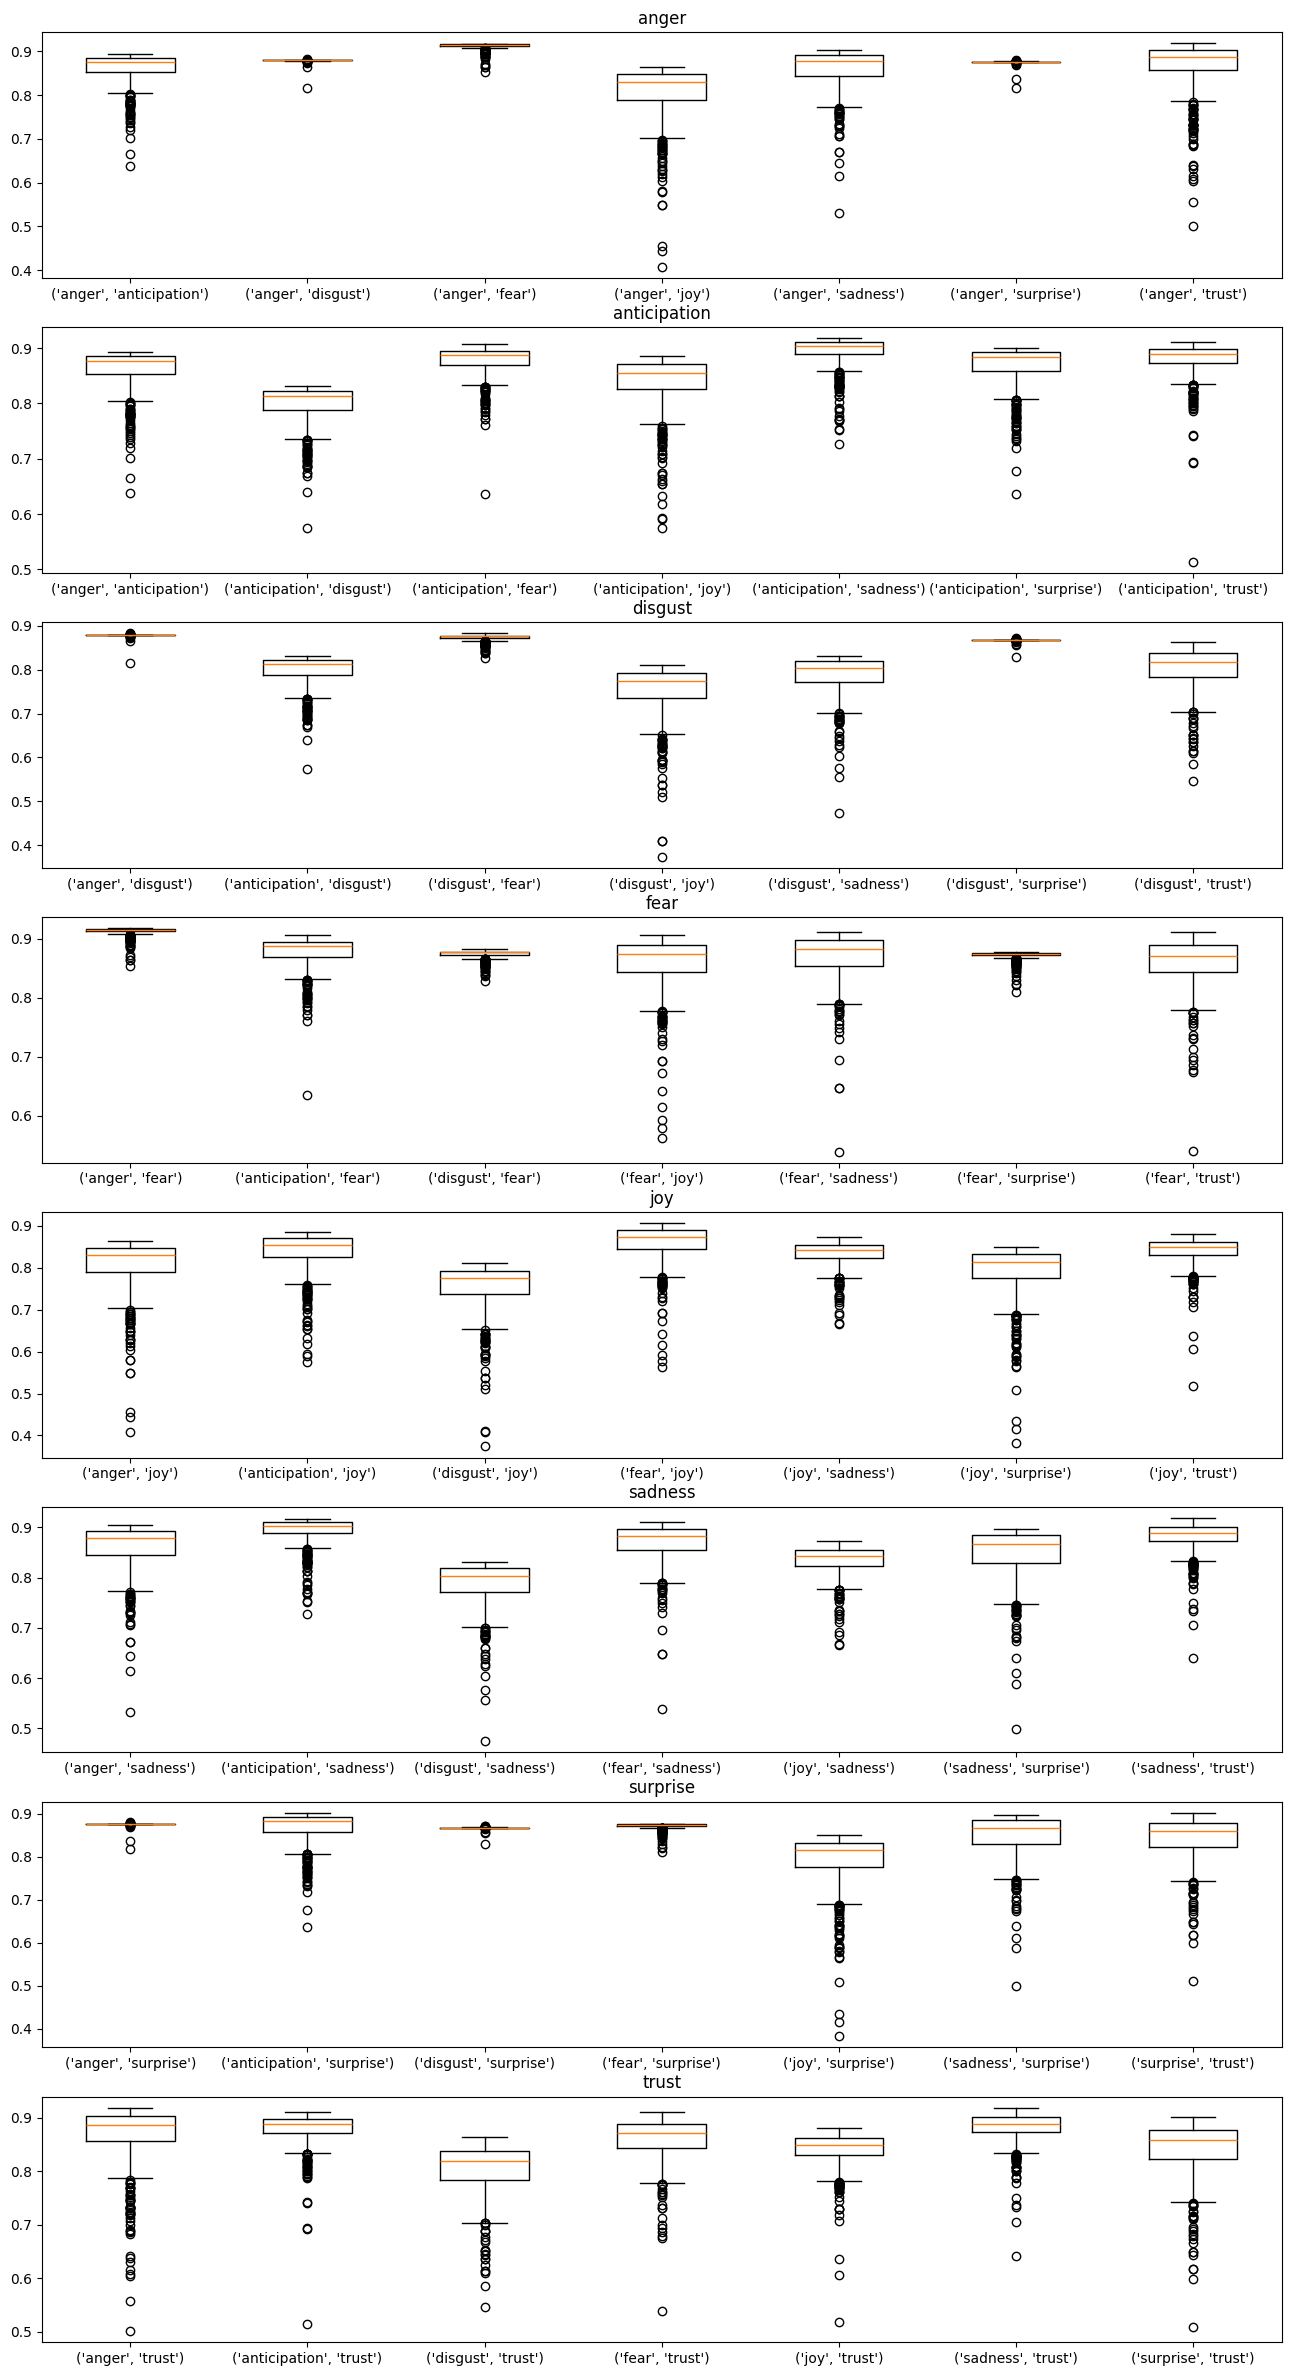

In [14]:
# Boxplots correlacion 
#sent = re.sub(r"[^\w .,;?!\n]+", "", sent)
import re
fig,ax = plt.subplots(8,figsize=(16,30))
columns = words_embbed_fst_info.columns
i = 0
for emotion in emotion_list:
    data = []
    labels = []
    for column in columns:
        if emotion in column:
            if 'f_' in column:
                continue
            data.append([element[0] for element in words_embbed_fst_info[column]])
            labels.append(re.sub(r"P_","",column))
    ax[i].boxplot(data)
    ax[i].set_xticklabels(labels)
    ax[i].set_title(emotion)
    i+=1

### Modulacion de embbedings

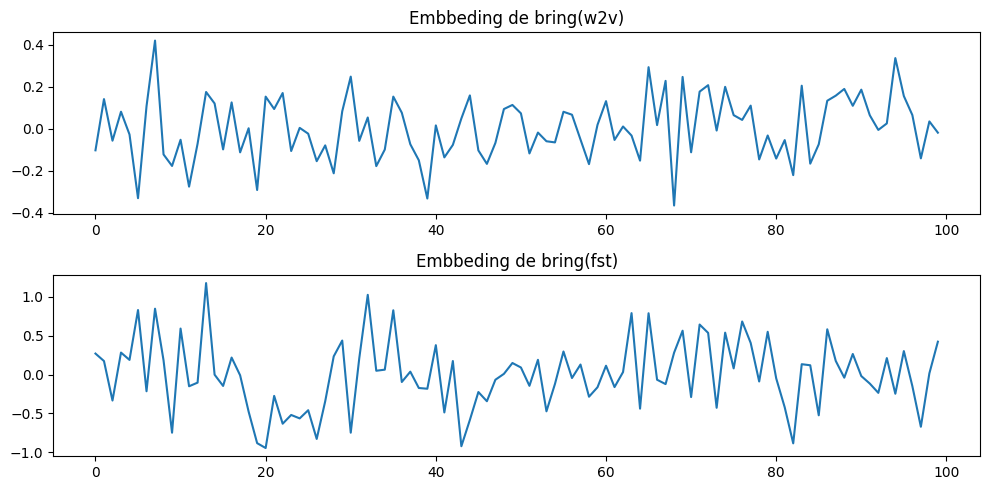

In [67]:
#Variables a ocupar
word = "bring"
emotion = "anger"
embbed_w2v = poems_w2v[emotion].wv.get_vector(word)
embbed_fst = poems_fst[emotion].wv.get_vector(word)

fig,ax = plt.subplots(2,figsize=(10,5))

ax[0].set_title("Embbeding de "+word+"(w2v)")
ax[0].plot(embbed_w2v)

ax[1].set_title("Embbeding de "+word+"(fst)")
ax[1].plot(embbed_fst)
fig.tight_layout()

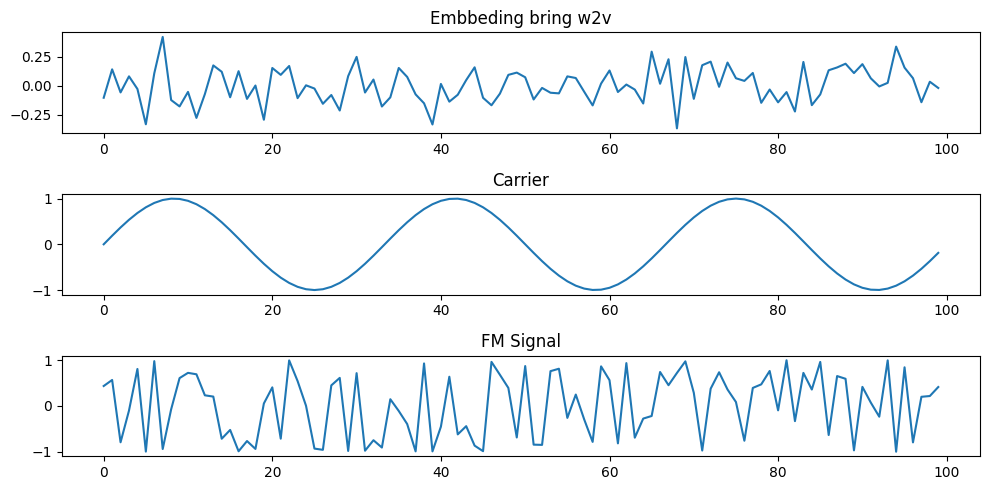

In [80]:
# Samples per second
sps = 100

# Duration
duration_s = 1.0

# ac: amplitude of the carrier. Should be kept at 1.0 in this script

# carrier_hz: Frequency of the carrier
# fm_hz: Frequency of the frequency modulator
# k_p: deviation constant
carrier_amplitude = 1.0
carrier_hz = 3.0
fm_hz = 50.0
k = 50

each_sample_number = np.arange(duration_s * sps)
carrier = 2 * np.pi * each_sample_number * carrier_hz / sps

#modulator = k * np.sin(2 * np.pi * each_sample_number * fm_hz / sps)
modulator = embbed_w2v
# Now create the modulated waveform, and attenuate it
waveform = np.cos(carrier + k*modulator)

fig,ax = plt.subplots(3,figsize=(10,5))
ax[0].set_title("Embbeding "+ word + " w2v")
ax[0].plot(embbed_w2v)

ax[1].set_title("Carrier")
ax[1].plot(np.sin(carrier))

ax[2].set_title("FM Signal")
ax[2].plot(waveform)
fig.tight_layout()

In [17]:
def modulate(x,carrier_hz,k,sps,duration_s):
    """Ocupa x para modular una carrier de amplitud 1 y frecuencia carrier_hz"""
    # Samples per second sps

    # Duration duration_s in seconds

    # carrier_hz: Frequency of the carrier
    # fm_hz: Frequency of the frequency modulator
    # k_p: deviation constant
    
    each_sample_number = np.arange(duration_s * sps)
    carrier = 2 * np.pi * each_sample_number * carrier_hz / sps

    modulator = x
    
    waveform = np.cos(carrier + k*modulator)

    return waveform

In [18]:
def create_correlation_df_mod(models,emotion_list,words_intersection,freq_dict,freq_a,freq_b,norm = False):
    emotion_combinations = list(combinations(emotion_list,2))

    words_embbed_info = {}
    words_embbed_info["words"] = list(words_intersection)

    for emotion in emotion_list:
        words_embbed_info["f_"+emotion] = []

    for comb in emotion_combinations:
        words_embbed_info["P_"+str(comb)] = []

    for word in words_intersection:
        #Añadimos la frecuencia por cada emoción
        for emotion in emotion_list:
            words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

        #Calculamos la correlacion pearson para cada par de emociones.    
        for comb in emotion_combinations:
            emotion_a = comb[0]
            emotion_b = comb[1]

            embbeding_a = models[emotion_a].wv.get_vector(word,norm=True)
            embbeding_b = models[emotion_b].wv.get_vector(word,norm=True)

            fm_embbed_a = modulate(embbeding_a,freq_a,50,100,1)
            fm_embbed_b = modulate(embbeding_b,freq_b,50,100,1)
            
            if norm:
                fm_embbed_a = fm_embbed_a/np.linalg.norm(fm_embbed_a)
                fm_embbed_b = fm_embbed_b/np.linalg.norm(fm_embbed_b)


            words_embbed_info["P_"+str(comb)].append(pearsonr(fm_embbed_a,fm_embbed_b))

    return pd.DataFrame(words_embbed_info)

In [19]:
words_embbed_fst_mod = create_correlation_df_mod(poems_fst,emotion_list,words_intersection,freq_dict,2,3)
words_embbed_w2v_mod = create_correlation_df_mod(poems_w2v,emotion_list,words_intersection,freq_dict,2,3)

display(words_embbed_fst_mod)
display(words_embbed_w2v_mod)

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,shadow,6,80,5,66,102,94,12,71,"(-0.0982951494111392, 0.33057714199657123)",...,"(-0.0452150557838589, 0.6550956713064694)","(-0.04490645852714341, 0.6573009659904009)","(-0.01094467270359542, 0.9139370449762305)","(-0.13039165724296187, 0.19599333429596105)","(0.021152135099511762, 0.8345377332772591)","(-0.007054923407561016, 0.9444618023503498)","(0.07176712936761251, 0.47797449131083014)","(0.08609907942859012, 0.39435332218735575)","(-0.1717703843674916, 0.08748176159440055)","(-0.014991780455335202, 0.8823101983278747)"
1,lake,12,31,10,27,33,63,9,47,"(-0.006104489113990208, 0.9519342564862557)",...,"(0.13180228151463236, 0.1911574703187493)","(-0.04361731838229535, 0.6665450305484045)","(-0.03235848066266166, 0.7492713816842415)","(-0.07568958062428917, 0.4541861743348516)","(0.07986778480911007, 0.4295864834980586)","(0.14169681356345418, 0.15964702470777836)","(0.13086461994951035, 0.19436219858512055)","(0.09318867901314878, 0.3564349973119459)","(-0.09537668614073849, 0.3452055561559527)","(0.011164734313945756, 0.9122134241231414)"
2,golden,16,147,9,51,160,95,10,117,"(-0.12833495218376917, 0.20320129573155912)",...,"(0.131618505507858, 0.19178254168807435)","(-0.032209534769688145, 0.7503875645673667)","(-0.02527551176962561, 0.8028833720568018)","(-0.07126481966206683, 0.48106852260569366)","(0.04481193809517267, 0.6579770162325984)","(-0.02811668954713435, 0.7812527711706231)","(-0.038511330445044574, 0.703639125603105)","(0.039951572765365255, 0.6931008740224384)","(-0.10017528224904892, 0.3213656304742043)","(-0.1128844655296028, 0.26346840031754915)"
3,well,62,204,54,133,255,208,24,359,"(0.11079402992589664, 0.27246949319935243)",...,"(0.047314796618283854, 0.6401698926455297)","(-0.0481917382148109, 0.6339779979143048)","(-0.07723504003624679, 0.44499720763042383)","(0.06650859731463876, 0.5108898742250287)","(0.0030086748054061075, 0.9762994962689399)","(-0.2123455899569136, 0.033920888230683385)","(0.008573147359186005, 0.9325355444788255)","(0.004761086320548157, 0.9625032360564005)","(0.011262712772958174, 0.9114461433838168)","(0.15001292640844224, 0.13629980293182717)"
4,young,20,208,6,32,330,58,38,42,"(0.0380239522866497, 0.7072181216472181)",...,"(0.1331906986436281, 0.1864827400298548)","(0.011424088716794619, 0.9101825670790935)","(-0.06550362096590356, 0.5173105246859758)","(0.001023739191382463, 0.9919345747320848)","(0.06654163348697625, 0.5106795091063082)","(0.012019694145712674, 0.9055209268722806)","(0.11698113801129834, 0.24642009805386025)","(0.05385994760873851, 0.5945774426442657)","(0.009180949308366293, 0.9277650445432664)","(-0.07494395789668007, 0.45865687017650886)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,heat,23,31,12,35,43,39,11,37,"(-0.06760109159600916, 0.5039568890005949)",...,"(0.1170199326413483, 0.2462623804124745)","(-0.020016854956878983, 0.843301913289984)","(0.016860763574367842, 0.8677637668356543)","(-0.09103673534925771, 0.36769777817181537)","(0.03344580583784284, 0.7411388906620241)","(0.18860585918373746, 0.060210458709491474)","(-0.004649994925163853, 0.963377543231187)","(0.17530839429875383, 0.0810578556901786)","(0.06469836009474214, 0.5224847409508865)","(0.059894211938391756, 0.5538882710886013)"
558,brought,18,73,8,41,53,40,8,68,"(-0.09526293625468644, 0.3457838190025712)",...,"(0.02878354094976144, 0.7761992545742764)","(-0.06390055812625102, 0.5276367225734229)","(-0.014491680466053211, 0.8862093569079105)","(-0.145641679989861, 0.14822561147829943)","(0.008027857873848793, 0.9368174346239335)","(0.06405922446690318, 0.5266100717662526)","(0.04858633474857671

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,shadow,6,80,5,66,102,94,12,71,"(0.037433198613874355, 0.7115647914952385)",...,"(0.08321535027513356, 0.41043961898990355)","(0.04362544928670066, 0.6664865677307632)","(-0.06991093623639803, 0.48946111640799933)","(-0.13896209265244447, 0.1679410374048054)","(0.004018061914745281, 0.9683517519097506)","(-0.007227005280323203, 0.9431093646914879)","(0.029257562903988493, 0.7726126832920615)","(-0.056989989829354576, 0.5733035519733217)","(-0.04756108032789117, 0.63842841983712)","(0.016089762989666113, 0.8737594655476871)"
1,lake,12,31,10,27,33,63,9,47,"(-0.028483327323684547, 0.7784731855356709)",...,"(-0.02798113298937829, 0.7822811633234262)","(-0.017955569977395013, 0.8592629184498142)","(0.048205682691389785, 0.6338797410005981)","(-0.2063349982968018, 0.039434164492963886)","(0.0012613767795234465, 0.9900624574648876)","(-0.04156906079866289, 0.6813351185592771)","(0.08217947240753, 0.4163104496981074)","(-0.05352429614656785, 0.5968796830914193)","(-0.11680862226253748, 0.24712229626705576)","(0.019846344148733507, 0.8446199087885334)"
2,golden,16,147,9,51,160,95,10,117,"(-0.09188985797307474, 0.36320687355050263)",...,"(0.05403143820735523, 0.593402729212424)","(-0.005682456415042509, 0.9552537127852004)","(0.007913824270965784, 0.937713116035496)","(-0.162100388400442, 0.10711438472871662)","(0.058011658544850096, 0.5664373691737733)","(-0.05221235660257401, 0.6059163663613181)","(0.15159513529366778, 0.13216779969450446)","(-0.06901917849960502, 0.4950311402832633)","(-0.09043670602685205, 0.3708766844443556)","(-0.012188015415810173, 0.9042040962293306)"
3,well,62,204,54,133,255,208,24,359,"(-0.06726517187469677, 0.5060834229641487)",...,"(-0.1493460113373381, 0.1380706042607698)","(-0.03001636547104099, 0.7668813606700203)","(0.06982522385242584, 0.48999503885809687)","(-0.01544789417677787, 0.878756434370843)","(-0.026060397557956663, 0.7968921997491384)","(0.008045614150749602, 0.936677974304436)","(0.02413502118554104, 0.8116092165776749)","(0.057956362261333855, 0.5668079947091322)","(0.004125434014695546, 0.9675064905078129)","(-0.002230815700013625, 0.9824258496604642)"
4,young,20,208,6,32,330,58,38,42,"(-0.13344276518182147, 0.18564304280319585)",...,"(-0.15893745324586278, 0.1142329525437311)","(0.15019403379248406, 0.13582191733826626)","(-0.0017045302980942516, 0.9865714301939575)","(0.00040555059977722687, 0.9968048656102475)","(0.05412801578654577, 0.5927416321267382)","(0.028144917942745047, 0.7810386653554003)","(-0.04765027833885634, 0.6377981839086228)","(0.01530704611211144, 0.8798535845473392)","(-0.010526466095262227, 0.9172137180201825)","(-0.227465972788467, 0.022846961096862583)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,heat,23,31,12,35,43,39,11,37,"(-0.0893668003348715, 0.376586478472562)",...,"(-0.07657403131646559, 0.4489145866059112)","(0.20268447643705778, 0.043134524120131364)","(-0.05381698937400792, 0.594871871046579)","(-0.132426545332327, 0.1890452071153234)","(0.0597259299226449, 0.5550045622181047)","(0.051534677632776464, 0.6106077285296333)","(-0.034034812878088204, 0.7367452934864626)","(0.06835484019062861, 0.4992022466814333)","(-0.12656687821778642, 0.20954801400305736)","(-0.0492465135954677, 0.6265637777289478)"
558,brought,18,73,8,41,53,40,8,68,"(-0.07943735379873622, 0.43208492011684513)",...,"(-0.1216377579540774, 0.2279844672157673)","(0.10495244499045835, 0.2987105303066978)","(0.17022217785114704, 0.09041709685877793)","(0.016109550006764586, 0.87360550070721)","(-0.006783111516541189, 0.9465983646550885)","(-0.033991117724534566, 0.7370709411871891)","(0.0080277857857

In [20]:
words_embbed_fst_mod_norm = create_correlation_df_mod(poems_fst,emotion_list,words_intersection,freq_dict,2,3,True)
words_embbed_w2v_mod_norm = create_correlation_df_mod(poems_w2v,emotion_list,words_intersection,freq_dict,2,3,True)

display(words_embbed_fst_mod_norm)
display(words_embbed_w2v_mod_norm)

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,shadow,6,80,5,66,102,94,12,71,"(-0.09829514941113918, 0.33057714199657123)",...,"(-0.045215055783858905, 0.6550956713064694)","(-0.04490645852714341, 0.6573009659904009)","(-0.010944672703595464, 0.9139370449762293)","(-0.1303916572429619, 0.19599333429596058)","(0.021152135099511776, 0.8345377332772591)","(-0.007054923407560995, 0.9444618023503498)","(0.07176712936761248, 0.47797449131083014)","(0.08609907942859016, 0.39435332218735575)","(-0.1717703843674916, 0.08748176159440055)","(-0.014991780455335203, 0.8823101983278747)"
1,lake,12,31,10,27,33,63,9,47,"(-0.006104489113990224, 0.9519342564862557)",...,"(0.13180228151463236, 0.1911574703187493)","(-0.04361731838229538, 0.6665450305484045)","(-0.03235848066266166, 0.7492713816842415)","(-0.07568958062428915, 0.4541861743348516)","(0.07986778480911005, 0.4295864834980586)","(0.14169681356345412, 0.15964702470777836)","(0.13086461994951037, 0.19436219858512055)","(0.09318867901314878, 0.3564349973119459)","(-0.0953766861407385, 0.3452055561559527)","(0.011164734313945764, 0.9122134241231414)"
2,golden,16,147,9,51,160,95,10,117,"(-0.12833495218376917, 0.20320129573155912)",...,"(0.13161850550785803, 0.19178254168807435)","(-0.032209534769688145, 0.7503875645673667)","(-0.02527551176962564, 0.8028833720568019)","(-0.07126481966206684, 0.48106852260569366)","(0.04481193809517265, 0.6579770162325984)","(-0.02811668954713434, 0.7812527711706231)","(-0.03851133044504458, 0.703639125603105)","(0.03995157276536525, 0.6931008740224384)","(-0.10017528224904892, 0.3213656304742043)","(-0.11288446552960277, 0.26346840031754915)"
3,well,62,204,54,133,255,208,24,359,"(0.11079402992589664, 0.27246949319935243)",...,"(0.047314796618283875, 0.6401698926455297)","(-0.04819173821481092, 0.6339779979143048)","(-0.07723504003624676, 0.44499720763042383)","(0.06650859731463878, 0.5108898742250287)","(0.0030086748054060884, 0.9762994962689399)","(-0.2123455899569136, 0.033920888230683385)","(0.008573147359185988, 0.9325355444788255)","(0.004761086320548136, 0.9625032360564005)","(0.01126271277295818, 0.9114461433838168)","(0.15001292640844224, 0.13629980293182717)"
4,young,20,208,6,32,330,58,38,42,"(0.038023952286649704, 0.7072181216472181)",...,"(0.13319069864362806, 0.1864827400298554)","(0.011424088716794588, 0.9101825670790935)","(-0.06550362096590359, 0.5173105246859758)","(0.0010237391913824343, 0.9919345747320848)","(0.06654163348697628, 0.5106795091063082)","(0.012019694145712672, 0.9055209268722806)","(0.11698113801129835, 0.24642009805386025)","(0.05385994760873853, 0.5945774426442657)","(0.009180949308366323, 0.9277650445432664)","(-0.07494395789668007, 0.45865687017650886)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,heat,23,31,12,35,43,39,11,37,"(-0.06760109159600916, 0.5039568890005949)",...,"(0.1170199326413483, 0.2462623804124745)","(-0.020016854956878976, 0.843301913289984)","(0.01686076357436783, 0.8677637668356543)","(-0.09103673534925774, 0.36769777817181537)","(0.03344580583784284, 0.7411388906620241)","(0.18860585918373746, 0.060210458709491474)","(-0.004649994925163859, 0.963377543231187)","(0.17530839429875383, 0.0810578556901786)","(0.06469836009474215, 0.5224847409508865)","(0.05989421193839177, 0.5538882710886013)"
558,brought,18,73,8,41,53,40,8,68,"(-0.09526293625468642, 0.3457838190025712)",...,"(0.028783540949761502, 0.7761992545742764)","(-0.06390055812625102, 0.5276367225734229)","(-0.01449168046605318, 0.8862093569079112)","(-0.145641679989861, 0.14822561147829943)","(0.0080278578738488, 0.9368174346239335)","(0.06405922446690318, 0.5266100717662526)","(0.04858633474857

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,shadow,6,80,5,66,102,94,12,71,"(0.03743319861387437, 0.7115647914952385)",...,"(0.0832153502751335, 0.41043961898990355)","(0.04362544928670068, 0.6664865677307632)","(-0.06991093623639803, 0.48946111640799933)","(-0.13896209265244447, 0.1679410374048054)","(0.004018061914745302, 0.9683517519097491)","(-0.0072270052803231925, 0.9431093646914879)","(0.029257562903988493, 0.7726126832920615)","(-0.056989989829354534, 0.5733035519733234)","(-0.04756108032789119, 0.63842841983712)","(0.016089762989666103, 0.8737594655476871)"
1,lake,12,31,10,27,33,63,9,47,"(-0.028483327323684582, 0.7784731855356709)",...,"(-0.027981132989378335, 0.7822811633234259)","(-0.017955569977394996, 0.8592629184498142)","(0.048205682691389785, 0.6338797410005981)","(-0.20633499829680177, 0.039434164492963886)","(0.001261376779523449, 0.9900624574648876)","(-0.04156906079866291, 0.6813351185592771)","(0.08217947240753001, 0.4163104496981074)","(-0.05352429614656785, 0.5968796830914193)","(-0.1168086222625375, 0.24712229626705576)","(0.019846344148733458, 0.8446199087885334)"
2,golden,16,147,9,51,160,95,10,117,"(-0.0918898579730747, 0.36320687355050263)",...,"(0.05403143820735522, 0.593402729212424)","(-0.005682456415042533, 0.9552537127852004)","(0.007913824270965784, 0.937713116035496)","(-0.16210038840044202, 0.10711438472871662)","(0.058011658544850096, 0.5664373691737733)","(-0.05221235660257407, 0.6059163663613181)","(0.15159513529366775, 0.13216779969450446)","(-0.06901917849960507, 0.4950311402832633)","(-0.09043670602685205, 0.3708766844443556)","(-0.012188015415810141, 0.9042040962293334)"
3,well,62,204,54,133,255,208,24,359,"(-0.06726517187469676, 0.5060834229641487)",...,"(-0.1493460113373381, 0.1380706042607698)","(-0.030016365471040994, 0.7668813606700203)","(0.06982522385242584, 0.48999503885809687)","(-0.01544789417677787, 0.878756434370843)","(-0.02606039755795665, 0.7968921997491384)","(0.008045614150749595, 0.936677974304436)","(0.024135021185541027, 0.8116092165776749)","(0.05795636226133388, 0.5668079947091322)","(0.00412543401469558, 0.9675064905078125)","(-0.0022308157000136596, 0.9824258496604642)"
4,young,20,208,6,32,330,58,38,42,"(-0.13344276518182144, 0.18564304280319585)",...,"(-0.15893745324586275, 0.1142329525437311)","(0.1501940337924841, 0.13582191733826626)","(-0.0017045302980942829, 0.9865714301939575)","(0.00040555059977721646, 0.9968048656102475)","(0.054128015786545775, 0.5927416321267382)","(0.02814491794274502, 0.7810386653554003)","(-0.047650278338856315, 0.6377981839086228)","(0.01530704611211143, 0.8798535845473392)","(-0.010526466095262237, 0.9172137180201825)","(-0.22746597278846695, 0.022846961096862583)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,heat,23,31,12,35,43,39,11,37,"(-0.08936680033487147, 0.376586478472562)",...,"(-0.07657403131646559, 0.4489145866059112)","(0.20268447643705775, 0.04313452412013187)","(-0.05381698937400791, 0.594871871046579)","(-0.13242654533232698, 0.1890452071153234)","(0.0597259299226449, 0.5550045622181047)","(0.051534677632776464, 0.6106077285296333)","(-0.03403481287808821, 0.7367452934864626)","(0.06835484019062864, 0.4992022466814333)","(-0.12656687821778645, 0.20954801400305736)","(-0.04924651359546772, 0.6265637777289478)"
558,brought,18,73,8,41,53,40,8,68,"(-0.07943735379873626, 0.43208492011684513)",...,"(-0.1216377579540774, 0.2279844672157673)","(0.10495244499045835, 0.2987105303066978)","(0.17022217785114704, 0.09041709685877793)","(0.01610955000676459, 0.87360550070721)","(-0.006783111516541177, 0.9465983646550885)","(-0.033991117724534566, 0.7370709411871891)","(0.0080277

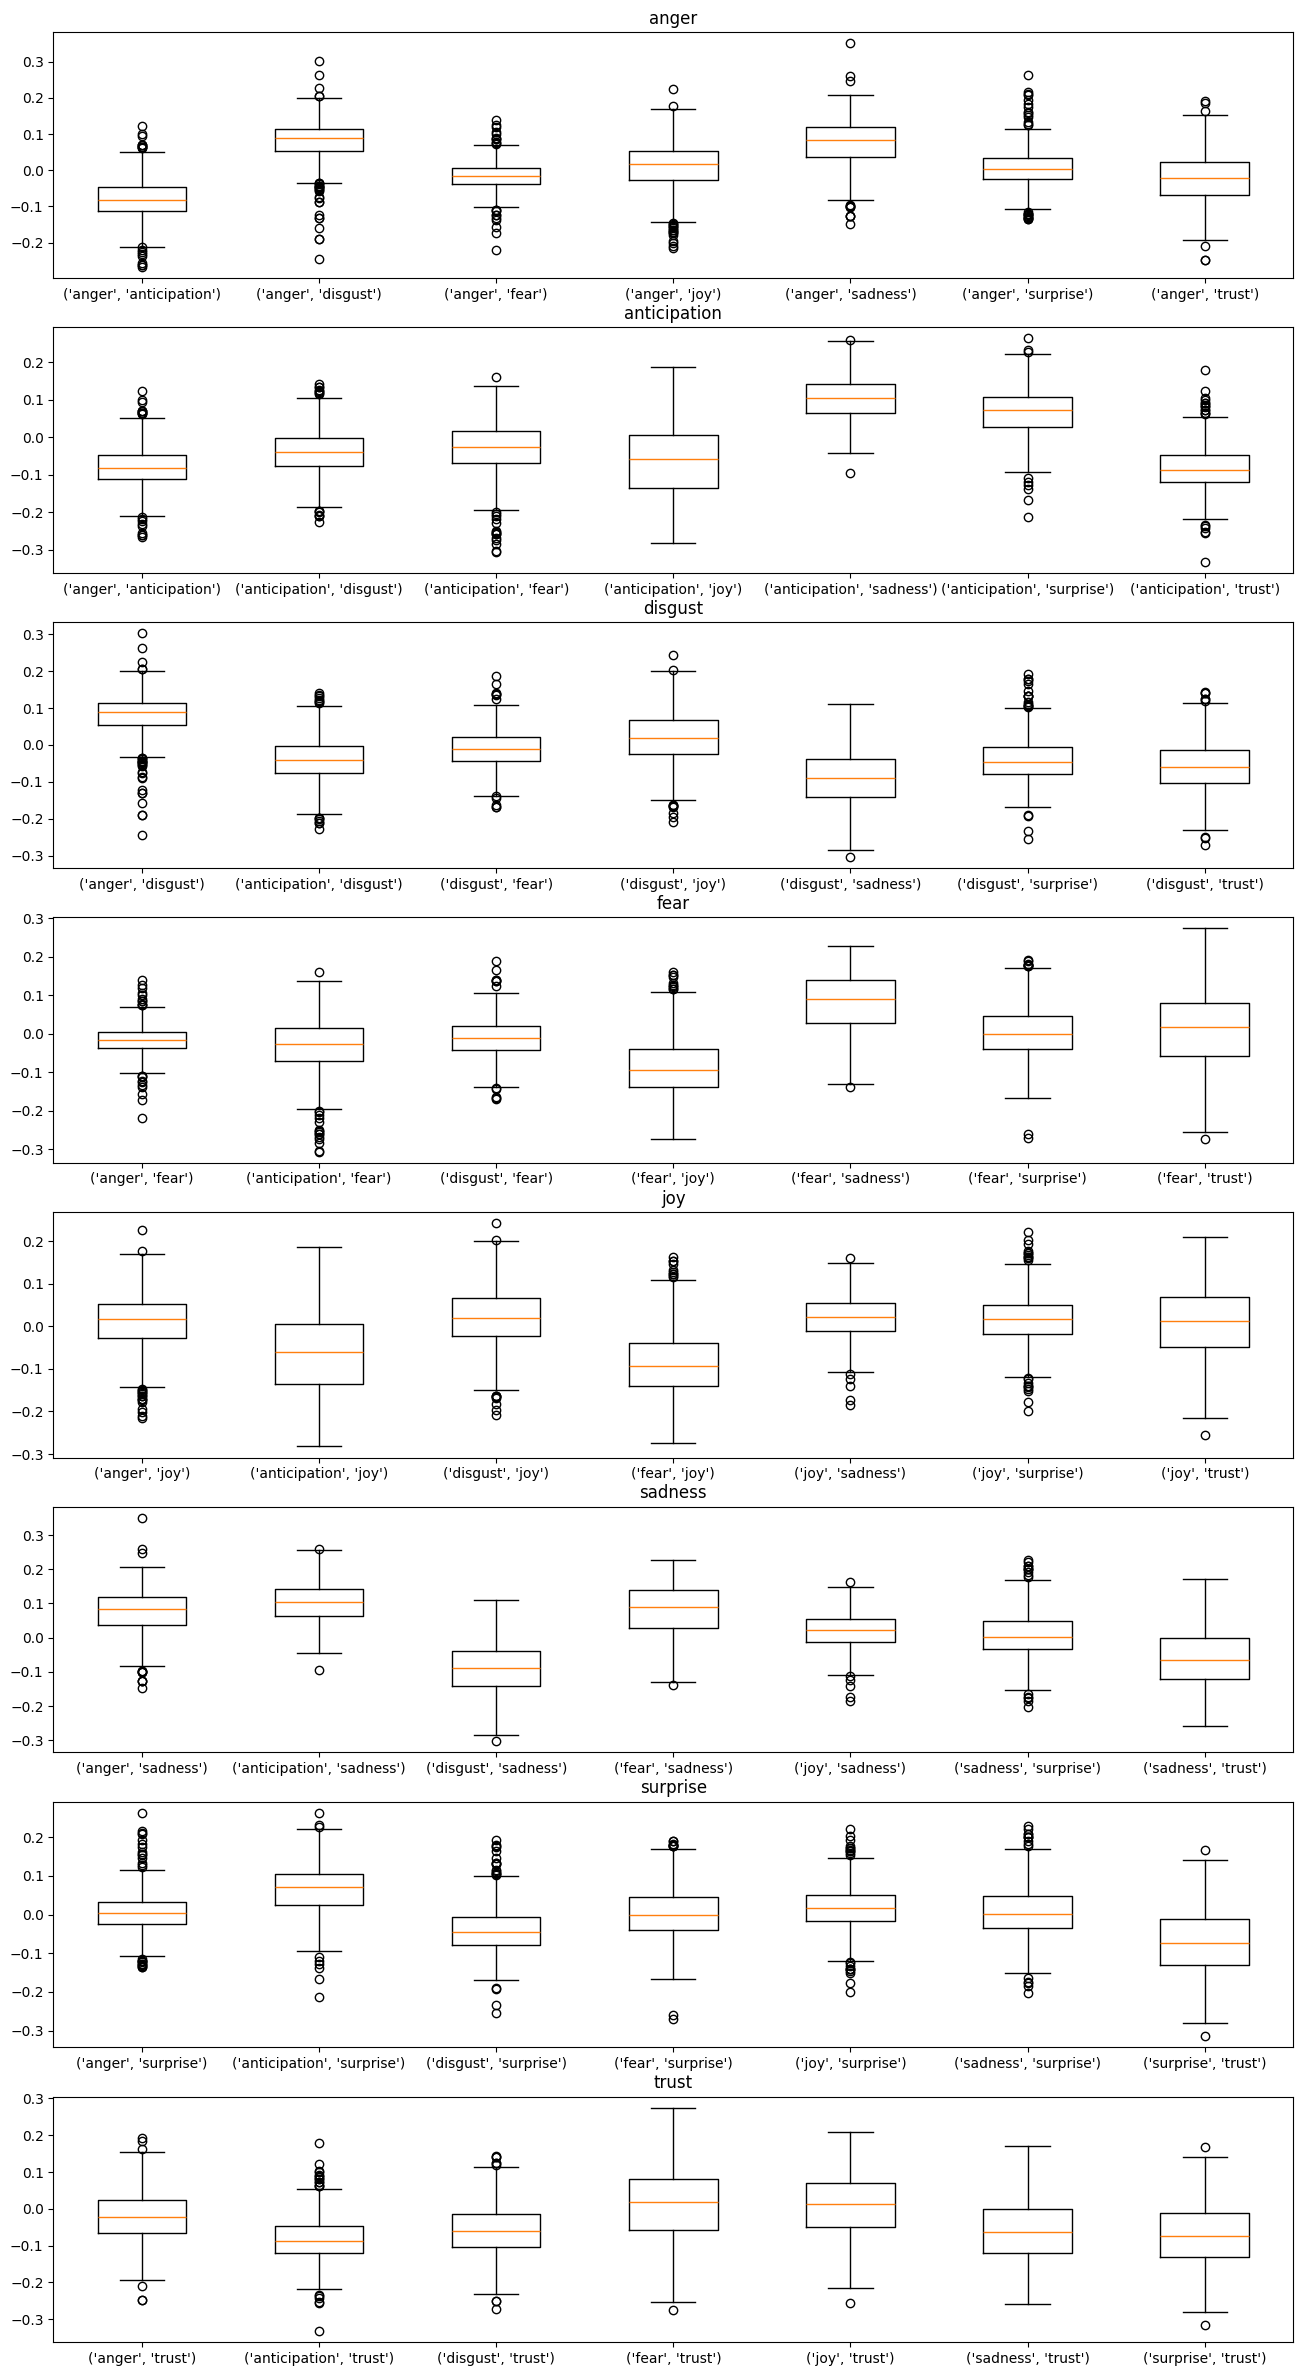

In [21]:
# Boxplots correlacion w2v modulados
import re
fig,ax = plt.subplots(8,figsize=(16,30))
columns = words_embbed_w2v_mod.columns
i = 0
for emotion in emotion_list:
    data = []
    labels = []
    for column in columns:
        if emotion in column:
            if 'f_' in column:
                continue
            data.append([element[0] for element in words_embbed_w2v_mod[column]])
            labels.append(re.sub(r"P_","",column))
    ax[i].boxplot(data)
    ax[i].set_xticklabels(labels)
    ax[i].set_title(emotion)
    i+=1

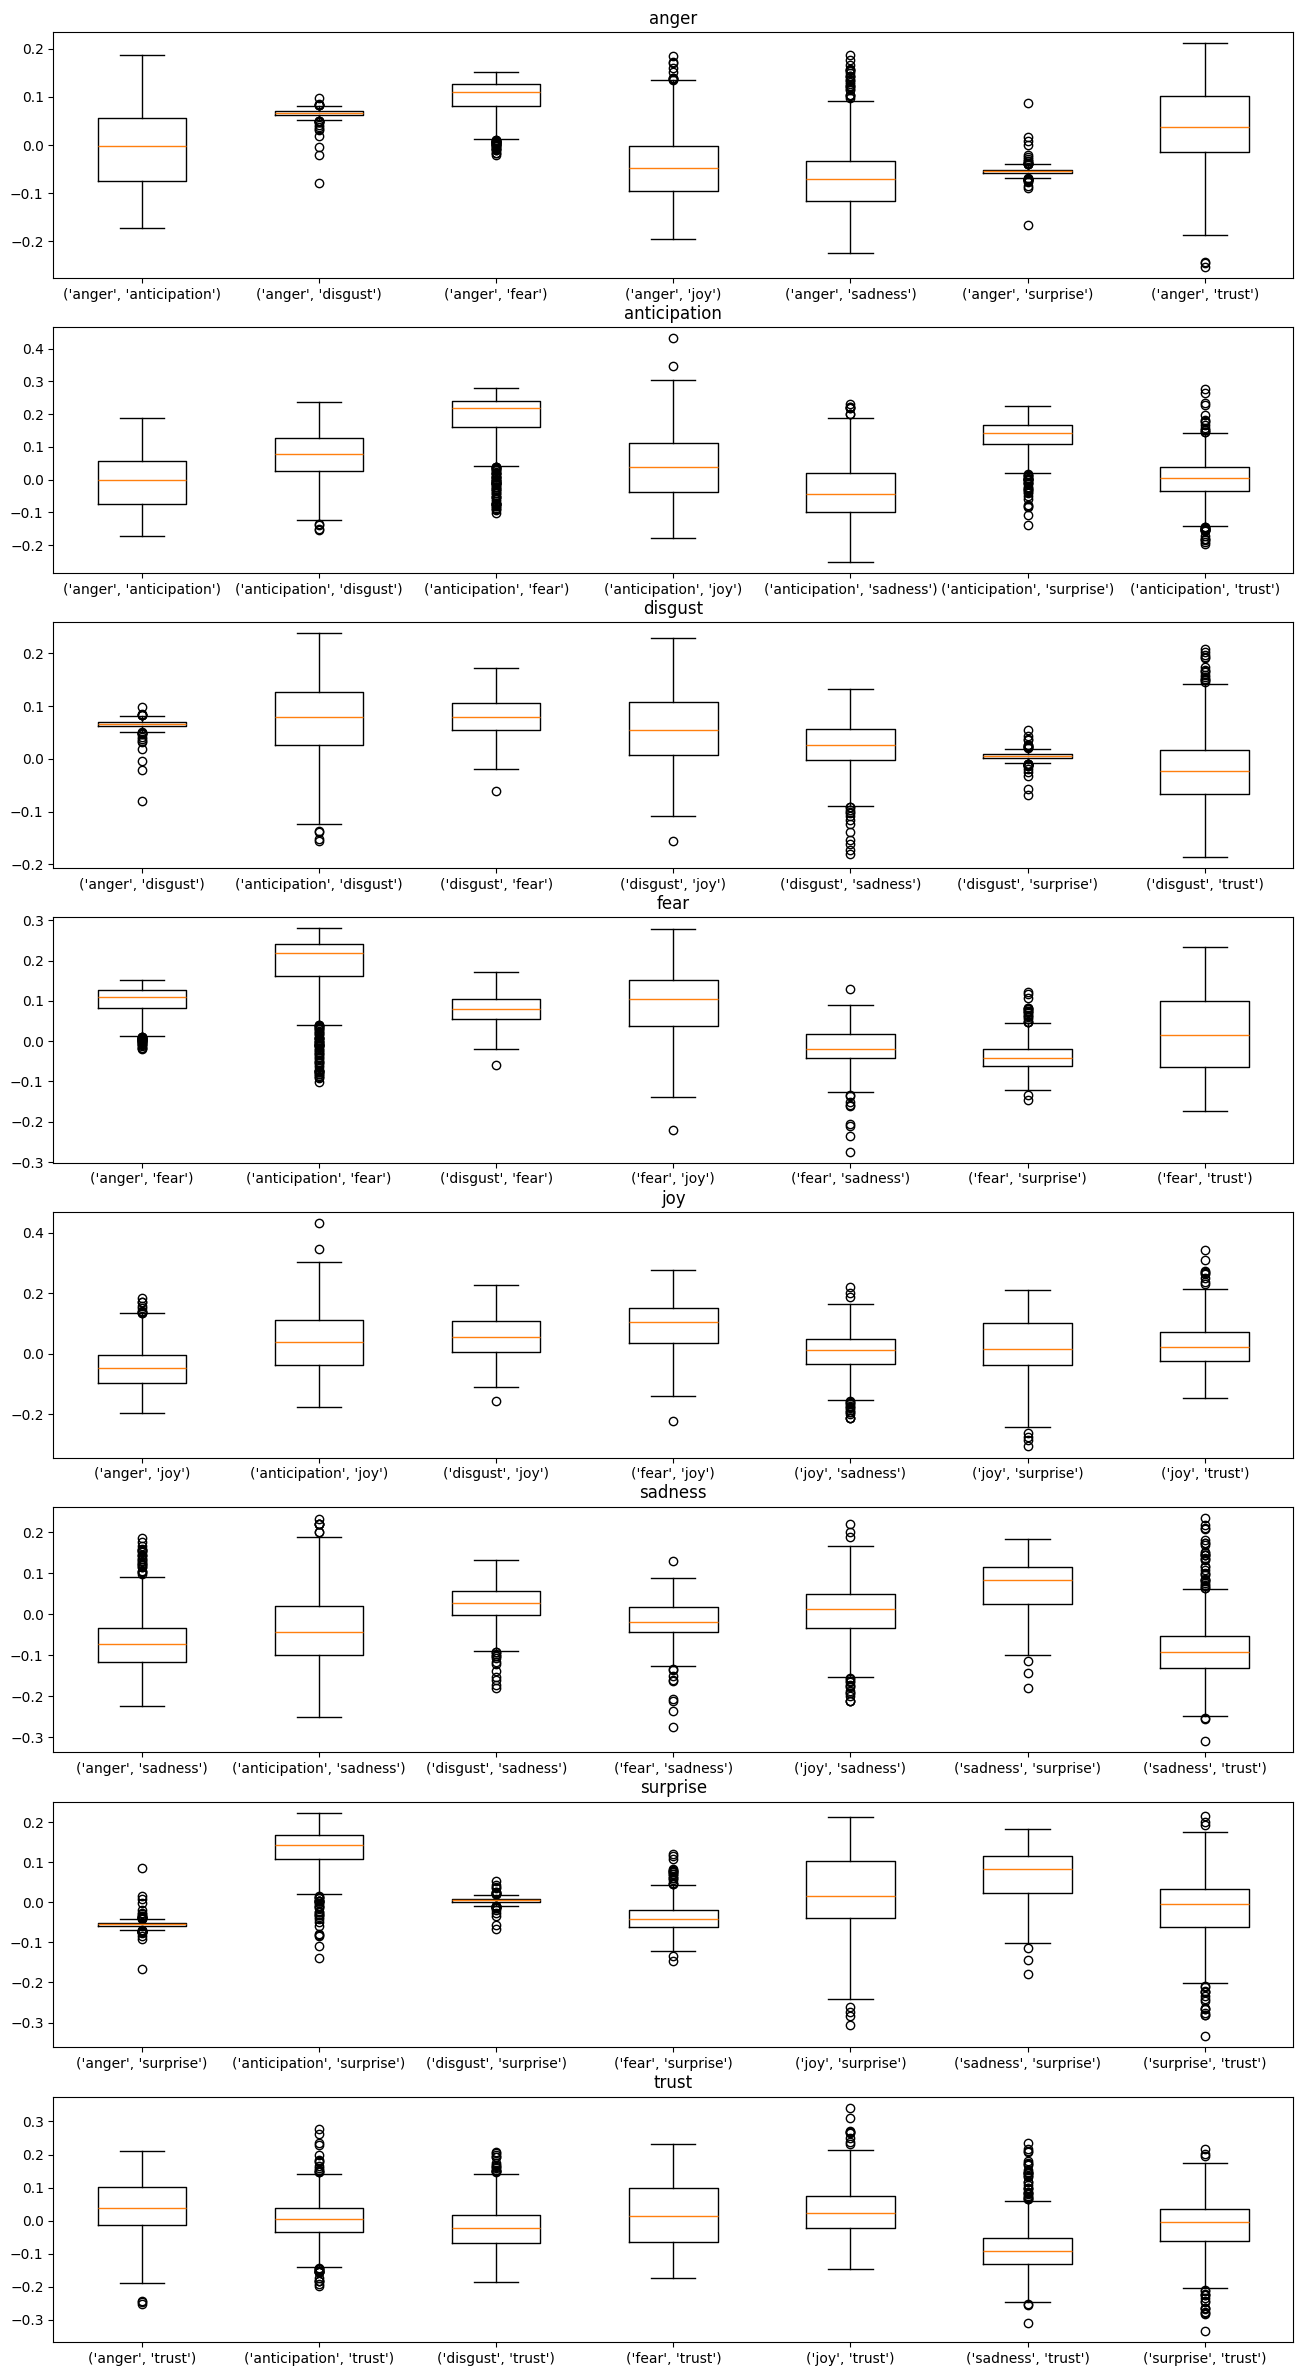

In [22]:
# Boxplots correlacion fst modulados
import re
fig,ax = plt.subplots(8,figsize=(16,30))
columns = words_embbed_fst_mod.columns
i = 0
for emotion in emotion_list:
    data = []
    labels = []
    for column in columns:
        if emotion in column:
            if 'f_' in column:
                continue
            data.append([element[0] for element in words_embbed_fst_mod[column]])
            labels.append(re.sub(r"P_","",column))
    ax[i].boxplot(data)
    ax[i].set_xticklabels(labels)
    ax[i].set_title(emotion)
    i+=1

## Uso de la frecuencia máxima para modulación de palabras

0.0


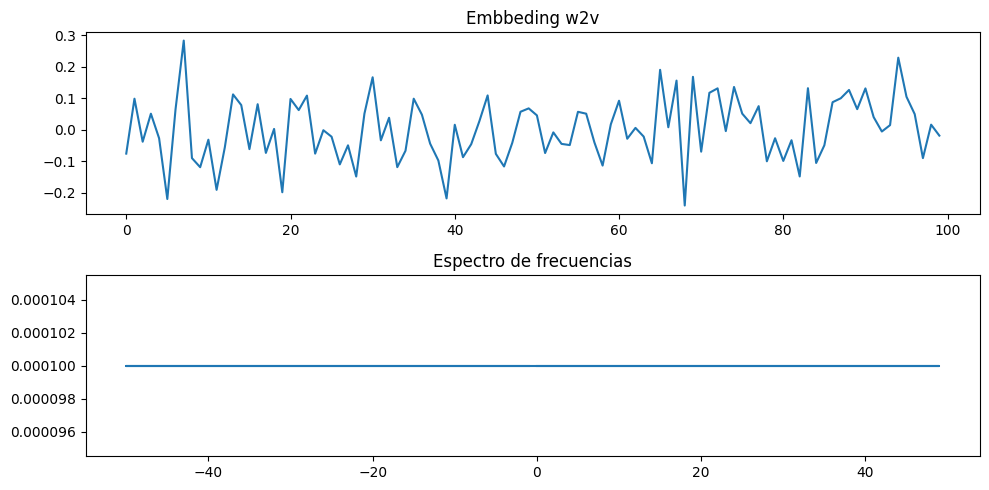

In [23]:
#Obtencion de espectro con MESA
from memspectrum import MESA

word = poems_w2v["anger"].wv.get_vector("for",norm=True)

M = MESA()
M.solve(word)
frecuencies,spectrum = M.spectrum(1/len(word))

fig,ax = plt.subplots(2,figsize=(10,5))

ax[0].set_title("Embbeding w2v")
ax[0].plot(word)

ax[1].set_title("Espectro de frecuencias")
ax[1].plot(frecuencies,spectrum)
fig.tight_layout()
print(frecuencies[np.argmax(spectrum)])

14.0


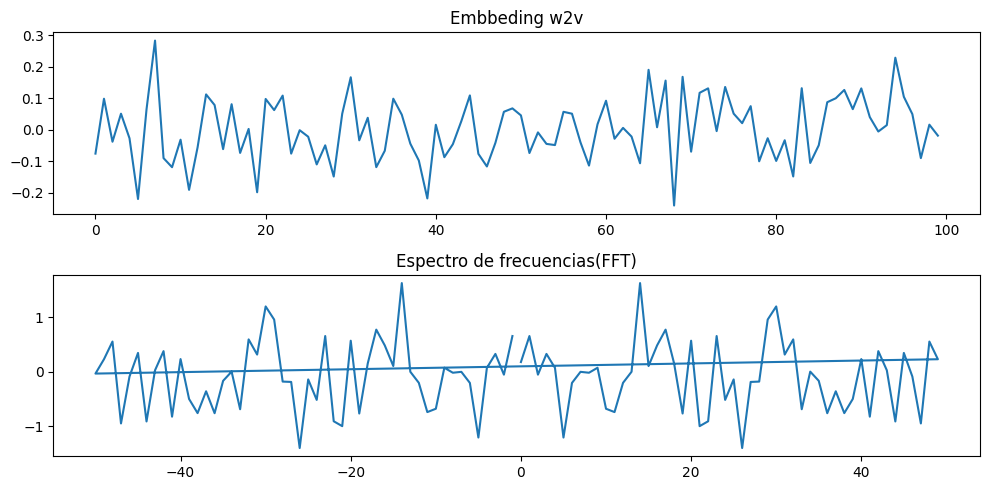

In [24]:
#Obtencion de espectro con numpy
sp = np.fft.fft(word)
freq = np.fft.fftfreq(len(word),d=1/len(word))

fig,ax = plt.subplots(2,figsize=(10,5))

ax[0].set_title("Embbeding w2v")
ax[0].plot(word)

ax[1].set_title("Espectro de frecuencias(FFT)")
ax[1].plot(freq,sp.real)
fig.tight_layout()

print(freq[np.argmax(sp.real)])

In [25]:
def get_max_freq(models,emotion_list,solver="maxent"):
    """Obtiene las frecuencias maximas de los espectros con maxent o numpy"""
    frequencies_dir = {}
    for emotion in emotion_list:
        frequencies_dir[emotion] = []

        words = models[emotion].wv.key_to_index.keys()
        
        M = MESA()
        for word in words:
            vector = models[emotion].wv.get_vector(word,norm=True)
            if solver == "maxent":
                M.solve(vector)
                frecuencies,spectrum = M.spectrum(1/len(vector))
                freq = frecuencies[np.argmax(spectrum[len(vector)//2:])]
            elif solver == "np":
                spectrum = np.fft.fft(vector)
                frecuencies = np.fft.fftfreq(len(vector),d=1/len(vector))
                freq = frecuencies[np.argmax(spectrum.real[len(vector)//2:])]
            frequencies_dir[emotion].append(freq)
    return frequencies_dir

In [26]:
freq_fst_maxent = get_max_freq(poems_fst,emotion_list)
freq_fst_np = get_max_freq(poems_fst,emotion_list,"np")

freq_w2v_maxent = get_max_freq(poems_w2v,emotion_list)
freq_w2v_np = get_max_freq(poems_w2v,emotion_list,"np")

[3.292419825072886, 2.732628593528426, 5.090008009611534, 2.850852949585438, 3.4056867225184058, 4.945, 2.8971153846153848, 2.601808615586978]
[49.0, 48.35871657754011, 48.98951612903226, 48.75073673870334, 41.755941681645695, 48.360400899979545, 49.0, 46.06849100860047]


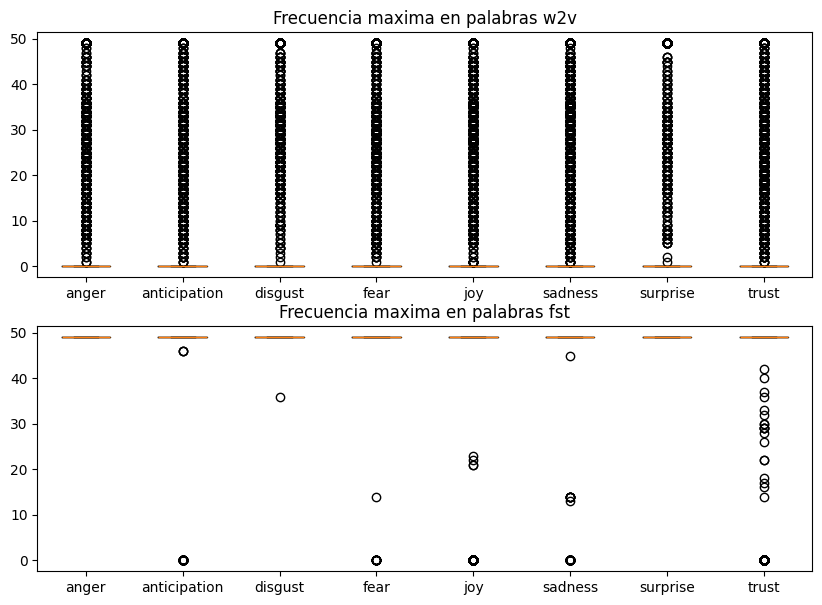

In [27]:
fig,ax = plt.subplots(2,figsize=(10,7))

labels = [label for label in freq_w2v_maxent.keys()]
data = [freq_w2v_maxent[label] for label in labels]
ax[0].boxplot(data)
ax[0].set_xticklabels(labels)
ax[0].set_title("Frecuencia maxima en palabras w2v")
medias_freq_spec_w2v = [np.mean(data[i]) for i in range(len(data))]
print(medias_freq_spec_w2v)

labels = [label for label in freq_fst_maxent.keys()]
data = [freq_fst_maxent[label] for label in labels]
ax[1].boxplot(data)
ax[1].set_xticklabels(labels)
ax[1].set_title("Frecuencia maxima en palabras fst")

medias_freq_spec_fst = [np.mean(data[i]) for i in range(len(data))]
print(medias_freq_spec_fst)

[31.471574344023324, 21.204159683726527, 31.857629154985982, 32.052463547126656, 29.815604637386816, 31.118235294117646, 27.37046703296703, 30.08605721802039]
[12.494880546075086, 44.23058823529412, 12.0, 13.679027504911591, 44.547833033752745, 16.53569237062794, 46.80520833333333, 27.001876465989053]


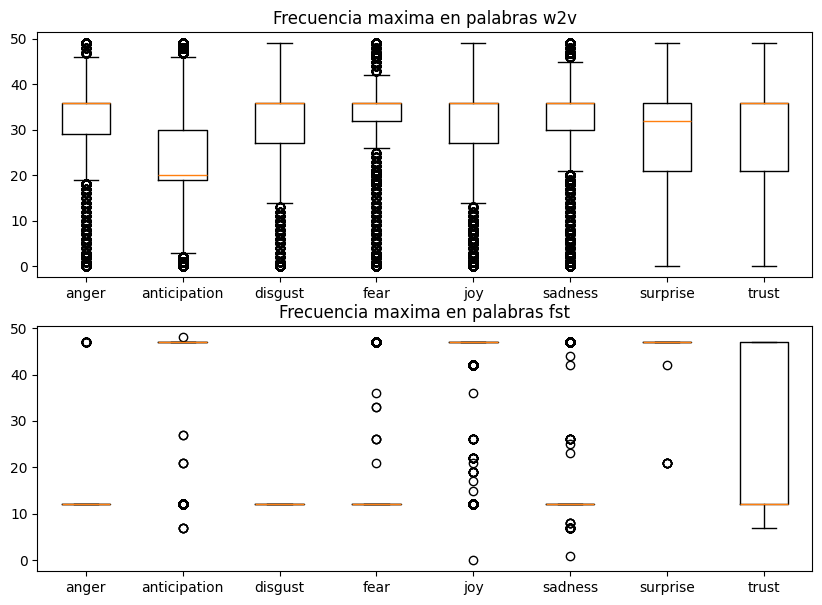

In [28]:
fig,ax = plt.subplots(2,figsize=(10,7))

labels = [label for label in freq_w2v_np.keys()]
data = [freq_w2v_np[label] for label in labels]
ax[0].boxplot(data)
ax[0].set_xticklabels(labels)
ax[0].set_title("Frecuencia maxima en palabras w2v")
medias_freq_spec_w2v = [np.mean(data[i]) for i in range(len(data))]
print(medias_freq_spec_w2v)

labels = [label for label in freq_fst_np.keys()]
data = [freq_fst_np[label] for label in labels]
ax[1].boxplot(data)
ax[1].set_xticklabels(labels)
ax[1].set_title("Frecuencia maxima en palabras fst")

medias_freq_spec_fst = [np.mean(data[i]) for i in range(len(data))]
print(medias_freq_spec_fst)

## Prueba de correlación

In [29]:
#Con los datos calculados obtenemos la media de cada clase
data = [freq_fst_maxent[label] for label in labels]
mean_fst_maxent = [np.mean(data[i]) for i in range(len(data))]

data = [freq_w2v_maxent[label] for label in labels]
mean_w2v_maxent = [np.mean(data[i]) for i in range(len(data))]

data = [freq_fst_np[label] for label in labels]
mean_fst_np = [np.mean(data[i]) for i in range(len(data))]

data = [freq_w2v_np[label] for label in labels]
mean_w2v_np = [np.mean(data[i]) for i in range(len(data))]

display(mean_fst_maxent,mean_w2v_maxent,mean_fst_np,mean_w2v_np)

[49.0,
 48.35871657754011,
 48.98951612903226,
 48.75073673870334,
 41.755941681645695,
 48.360400899979545,
 49.0,
 46.06849100860047]

[3.292419825072886,
 2.732628593528426,
 5.090008009611534,
 2.850852949585438,
 3.4056867225184058,
 4.945,
 2.8971153846153848,
 2.601808615586978]

[12.494880546075086,
 44.23058823529412,
 12.0,
 13.679027504911591,
 44.547833033752745,
 16.53569237062794,
 46.80520833333333,
 27.001876465989053]

[31.471574344023324,
 21.204159683726527,
 31.857629154985982,
 32.052463547126656,
 29.815604637386816,
 31.118235294117646,
 27.37046703296703,
 30.08605721802039]

In [30]:
def scale(x):
    """Escala entre 0 y 1 los valores de x"""
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [31]:
#Escalamos entre 0 y 1 los valores medios de las frecuencias
mean_fst_maxent = scale(mean_fst_maxent)
mean_w2v_maxent = scale(mean_w2v_maxent)
mean_fst_np = scale(mean_fst_np)
mean_w2v_np = scale(mean_w2v_np)

display(mean_fst_maxent,mean_w2v_maxent,mean_fst_np,mean_w2v_np)

array([1.        , 0.91147456, 0.99855276, 0.96559066, 0.        ,
       0.91170707, 1.        , 0.59532228])

array([0.27755461, 0.05257616, 1.        , 0.10009018, 0.32307624,
       0.94172171, 0.11868292, 0.        ])

array([0.01421858, 0.92602773, 0.        , 0.0482407 , 0.9351426 ,
       0.13031648, 1.        , 0.4310239 ])

array([0.94645345, 0.        , 0.98204011, 1.        , 0.79380565,
       0.91388255, 0.56841212, 0.81873606])

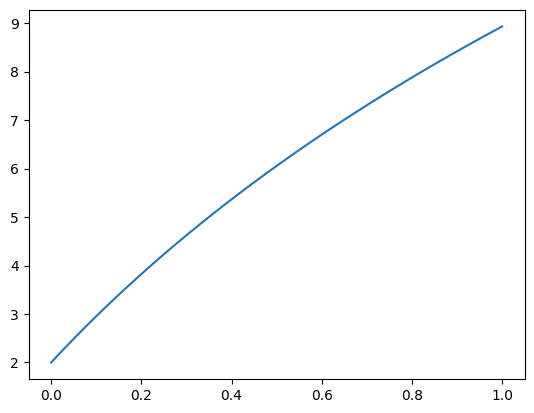

In [33]:
#Usaremos la siguiente funcion para boostear las diferencias entre la frecuencias
x = np.linspace(0,1,100)
y = 10*np.log(1+x) + 2
plt.plot(x,y)

In [35]:
#Usaremos primero maxent
frecuencies_fst = mean_fst_maxent.copy()
frecuencies_fst = 10*np.log(1 + frecuencies_fst) + 2

frecuencies_w2v = mean_w2v_maxent.copy()
frecuencies_w2v = 10*np.log(1 + frecuencies_w2v)

print("FastText freq: ",frecuencies_fst)
print("w2v freq",frecuencies_w2v)

FastText freq:  [8.93147181 8.47874967 8.924233   8.75792791 2.         8.47996599
 8.93147181 6.67075773]
w2v freq [2.44947789 0.51240648 6.93147181 0.95392161 2.79959511 6.63575058
 1.12152029 0.        ]


In [36]:
emotion_carrier_frecuencies_fst = {}
emotion_carrier_frecuencies_w2v = {}
for emotion,i in zip(emotion_list,range(8)):
    emotion_carrier_frecuencies_fst[emotion] = frecuencies_fst[i]
    emotion_carrier_frecuencies_w2v[emotion] = frecuencies_w2v[i]

display(emotion_carrier_frecuencies_w2v,emotion_carrier_frecuencies_fst)

{'anger': 2.44947788815791,
 'anticipation': 0.5124064824300384,
 'disgust': 6.931471805599453,
 'fear': 0.9539216146783323,
 'joy': 2.7995951078937265,
 'sadness': 6.63575058103783,
 'surprise': 1.121520288183776,
 'trust': 0.0}

{'anger': 8.931471805599454,
 'anticipation': 8.478749671362777,
 'disgust': 8.924233000015743,
 'fear': 8.757927907899548,
 'joy': 2.0,
 'sadness': 8.479965992800018,
 'surprise': 8.931471805599454,
 'trust': 6.670757733271237}

In [37]:
def create_correlation_df_mod_per_emotion(models,emotion_list,words_intersection,frecuencies,norm = False):
    emotion_combinations = list(combinations(emotion_list,2))

    words_embbed_info = {}
    words_embbed_info["words"] = list(words_intersection)

    for emotion in emotion_list:
        words_embbed_info["f_"+emotion] = []

    for comb in emotion_combinations:
        words_embbed_info["P_"+str(comb)] = []

    for word in words_intersection:
        #Añadimos la frecuencia por cada emoción
        for emotion in emotion_list:
            words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

        #Calculamos la correlacion pearson para cada par de emociones.    
        for comb in emotion_combinations:
            emotion_a = comb[0]
            emotion_b = comb[1]

            embbeding_a = models[emotion_a].wv.get_vector(word,norm=True)
            embbeding_b = models[emotion_b].wv.get_vector(word,norm=True)

            fm_embbed_a = modulate(embbeding_a,frecuencies[emotion_a],50,100,1)
            fm_embbed_b = modulate(embbeding_b,frecuencies[emotion_b],50,100,1)
            
            if norm:
                fm_embbed_a = fm_embbed_a/np.linalg.norm(fm_embbed_a)
                fm_embbed_b = fm_embbed_b/np.linalg.norm(fm_embbed_b)


            words_embbed_info["P_"+str(comb)].append(pearsonr(fm_embbed_a,fm_embbed_b))

    return pd.DataFrame(words_embbed_info)

In [38]:
mod_per_emotion_info_w2v = create_correlation_df_mod_per_emotion(poems_w2v,emotion_list,words_intersection,emotion_carrier_frecuencies_w2v,norm=True)
mod_per_emotion_info_fst = create_correlation_df_mod_per_emotion(poems_fst,emotion_list,words_intersection,emotion_carrier_frecuencies_fst,norm=True)

display(mod_per_emotion_info_w2v,mod_per_emotion_info_fst)

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,shadow,6,80,5,66,102,94,12,71,"(-0.018176845957675207, 0.8575466928366579)",...,"(-0.21455084550770123, 0.032067927319603035)","(0.0142911289456748, 0.8877737762316006)","(0.10395527435230163, 0.30335056117423254)","(0.022999537955559715, 0.8203197011831193)","(-0.039066708951455996, 0.6995686480234365)","(-0.03272259924557691, 0.7465449007215029)","(-0.039878440068130634, 0.693634599701873)","(0.16014002710793923, 0.11148440689776122)","(0.027125398268628798, 0.7887817292254681)","(0.08298605707699037, 0.4117349455795923)"
1,lake,12,31,10,27,33,63,9,47,"(-0.0038863228759991753, 0.9693888839927045)",...,"(-0.25082875793869486, 0.011831529870074535)","(-0.041476557386611754, 0.6820059759554687)","(-0.008578651516328197, 0.9324923326306515)","(0.022885997214401394, 0.8211919115550144)","(0.03906438056192564, 0.6995856956108143)","(-0.19706052369536933, 0.049397485352704)","(-0.060687754942117686, 0.5486389739636187)","(0.054108582247236914, 0.5928746327226785)","(-0.1775152982146393, 0.0772456059816647)","(-0.013285844930156668, 0.8956219495174809)"
2,golden,16,147,9,51,160,95,10,117,"(-0.0988233341519354, 0.327972528292)",...,"(-0.11207572465651211, 0.26692645382027336)","(0.0025368665506383583, 0.9800152772031545)","(-0.05813533570771564, 0.5656088326400036)","(-0.025670664981024383, 0.7998656482318485)","(0.031668640678700385, 0.754445273530817)","(-0.13806308312264573, 0.1707359987860608)","(-0.04219215123060652, 0.6768227992192636)","(0.16225710845953284, 0.10677087711526144)","(-0.16137520869658578, 0.10871510875029089)","(-0.004615807712261194, 0.9636466108760992)"
3,well,62,204,54,133,255,208,24,359,"(0.036142559305585104, 0.7210931129475318)",...,"(-0.16152735762942394, 0.10837772788649926)","(-0.17103584724017915, 0.0888648341193077)","(-0.11102673174606141, 0.2714573915790256)","(0.02448193820743383, 0.8089524771021724)","(0.059145412725475105, 0.5588636842025874)","(-0.031869694098899976, 0.7529362138541518)","(0.04498332725880056, 0.656751371659559)","(0.03906327986386052, 0.6995937545575817)","(-0.05754903018189224, 0.5695416753226925)","(-0.042445109307028384, 0.6749941619420327)"
4,young,20,208,6,32,330,58,38,42,"(-0.012699473139644384, 0.9002044064203892)",...,"(-0.2377313274272555, 0.01723403744576637)","(-0.09422414820526011, 0.35109272483073967)","(-0.03794850774060159, 0.7077727107547235)","(-0.04520537133462015, 0.6551648333487838)","(-0.07350650617389642, 0.4673438704488514)","(-0.19986369221706507, 0.04618784381956949)","(-0.09136429081211496, 0.3659694886502334)","(0.15656032311711807, 0.11982020903504961)","(0.05437165534618621, 0.5910753390421932)","(0.12102405906679058, 0.2303571500683925)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,heat,23,31,12,35,43,39,11,37,"(-0.027773363113074094, 0.7838581246849095)",...,"(-0.28024297639526907, 0.004742579416292098)","(-0.009371661598204736, 0.9262687056699099)","(0.08767775029213688, 0.3857084499572515)","(-0.020785813709495553, 0.8373635192311332)","(-0.09802518501792921, 0.33191348059774495)","(-0.18072188657682361, 0.07196423104021407)","(-0.04516406185719948, 0.6554598800241591)","(0.1302421225286825, 0.19651109301061634)","(0.10907797415821655, 0.2800116873813626)","(-0.03796511907709195, 0.7076505885301398)"
558,brought,18,73,8,41,53,40,8,68,"(0.02567990353237985, 0.7997951298438186)",...,"(-0.21952009430211455, 0.02820358460694928)","(-0.19519750110089118, 0.051630907730186366)","(-0.030594566168493306, 0.762522540280883)","(-0.09579409363041266, 0.3430888143134457)","(-0.14952504707328307, 0.13759352114566692)","(-0.18011339610229227, 0.07294340198269003)"

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,shadow,6,80,5,66,102,94,12,71,"(-0.18205002954014995, 0.06986381778701307)",...,"(-0.05023375808552791, 0.6196577279192621)","(0.07584782787245274, 0.45324045771098476)","(-0.03787806584623477, 0.708290663443256)","(-0.0068493860739405905, 0.9460773817261465)","(-0.11392827084858842, 0.25905041804999757)","(0.015705824534911685, 0.8767478555317617)","(-0.10534758360301211, 0.2968848479129252)","(0.06843338293986863, 0.4987081528521474)","(-0.0405737830905082, 0.6885660428155839)","(-0.06532166817700764, 0.5184773767430434)"
1,lake,12,31,10,27,33,63,9,47,"(-0.20092612186203607, 0.04501743713424035)",...,"(-0.13884474161809854, 0.16830394222230552)","(0.1416656933219229, 0.1597396596103769)","(-0.06381283827990265, 0.5282047449861064)","(0.002746792154796171, 0.9783619261797062)","(-0.013388422558264754, 0.8948206600451518)","(-0.004264661271026943, 0.9664105105978353)","(0.12751901352043057, 0.20611286748879973)","(0.10423117758062345, 0.3020620352439176)","(-0.09163828406220102, 0.36452765104123025)","(-0.1919254005621266, 0.055754676232293986)"
2,golden,16,147,9,51,160,95,10,117,"(-0.16577078653454488, 0.0992928198365266)",...,"(0.008655373660326853, 0.9318900255046524)","(0.008926364165581, 0.9297629243961105)","(-0.05356888776881499, 0.5965735982508032)","(0.005567286875740502, 0.9561597024970908)","(-0.0261106199547246, 0.7965092401184323)","(0.08074076325978846, 0.42454473903862056)","(0.09856594727013533, 0.32924012669136565)","(-0.0038920048123384995, 0.9693441511729091)","(-0.033775832680645754, 0.7386760778929838)","(-0.06800444021809661, 0.5014096452091257)"
3,well,62,204,54,133,255,208,24,359,"(0.20407461280126918, 0.04169271052864275)",...,"(-0.007954063335522212, 0.9373970478049819)","(0.06264709984477462, 0.5357823918376883)","(-0.1057054894478889, 0.2952375491019369)","(0.01160027807907544, 0.9088032569489984)","(0.11020847398463977, 0.27502751716809226)","(-0.18247867926248101, 0.0691965967851078)","(0.06777842041151781, 0.5028361872635028)","(-0.05544741055517732, 0.5837435490834277)","(0.1080576397372155, 0.28456173201343155)","(0.024633667999366518, 0.8077911882671683)"
4,young,20,208,6,32,330,58,38,42,"(-0.09531138830488958, 0.3455374322250244)",...,"(-0.1024635375726769, 0.3103794956284735)","(0.19131488193713597, 0.056553231933469714)","(-0.09874683510729006, 0.3283489505520269)","(-0.08228135697938097, 0.4157308653329603)","(0.011013673667953017, 0.9133965553219136)","(-0.018995523714157247, 0.8512028177251227)","(0.19131905538598487, 0.05654774143329914)","(0.053899729380168925, 0.5943048436641448)","(0.02251956889144171, 0.8240082628710652)","(-0.11194953321744258, 0.2674687887096436)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,heat,23,31,12,35,43,39,11,37,"(-0.1504598761957562, 0.13512275146343028)",...,"(-0.10030856075466407, 0.3207189725450323)","(0.13503862886492263, 0.1803906265265006)","(-0.014096266895293159, 0.8892942268519558)","(-0.032029768565016235, 0.7517353965185215)","(-0.042859105372888395, 0.6720054550970233)","(0.0402862362145154, 0.6906604016012594)","(0.16224703199969276, 0.1067929373640289)","(0.1267225464070229, 0.20898361519763603)","(0.01881408017717399, 0.8526080079128944)","(-0.09963494474956117, 0.32399589273047774)"
558,brought,18,73,8,41,53,40,8,68,"(-0.2279007038240563, 0.02258089344688994)",...,"(-0.07366873980701101, 0.46635896477090927)","(0.1394318725629766, 0.16649404877183221)","(-0.04380686176527362, 0.6651826952425888)","(-0.027464779053161237, 0.7862018719946747)","(-0.009770808783000618, 0.923137812501076)","(-0.012334175332972756, 0.9030608511309722)","(0.023626705

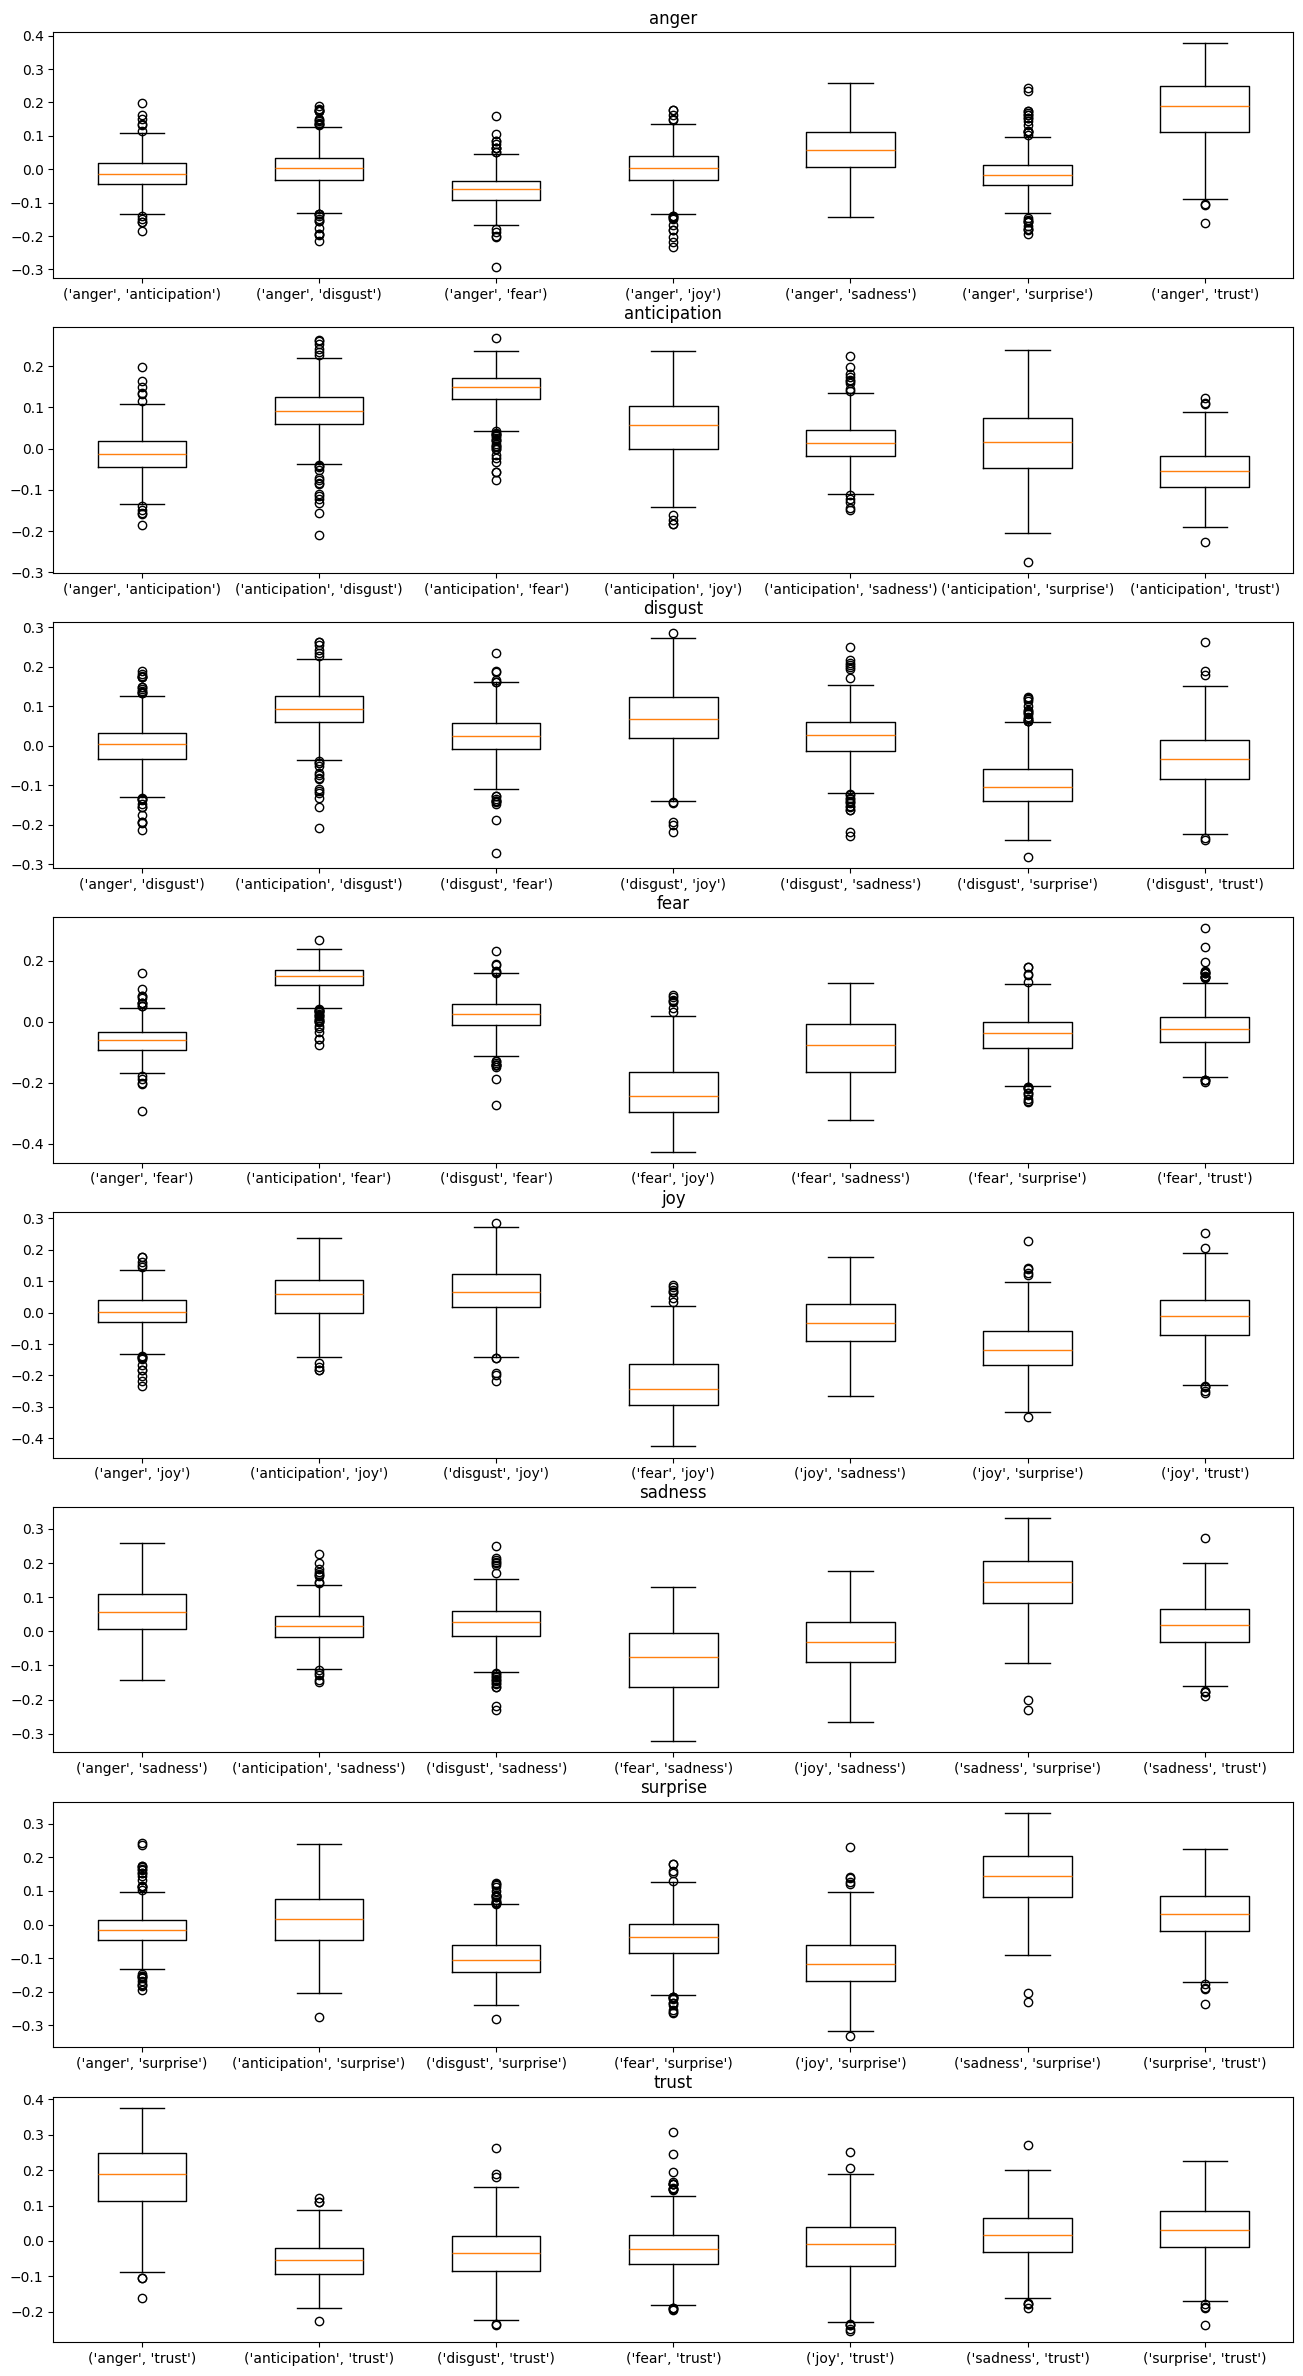

In [39]:
# Boxplots correlacion w2v modulados
import re
fig,ax = plt.subplots(8,figsize=(16,30))
columns = mod_per_emotion_info_w2v.columns
i = 0
for emotion in emotion_list:
    data = []
    labels = []
    for column in columns:
        if emotion in column:
            if 'f_' in column:
                continue
            data.append([element[0] for element in mod_per_emotion_info_w2v[column]])
            labels.append(re.sub(r"P_","",column))
    ax[i].boxplot(data)
    ax[i].set_xticklabels(labels)
    ax[i].set_title(emotion)
    i+=1

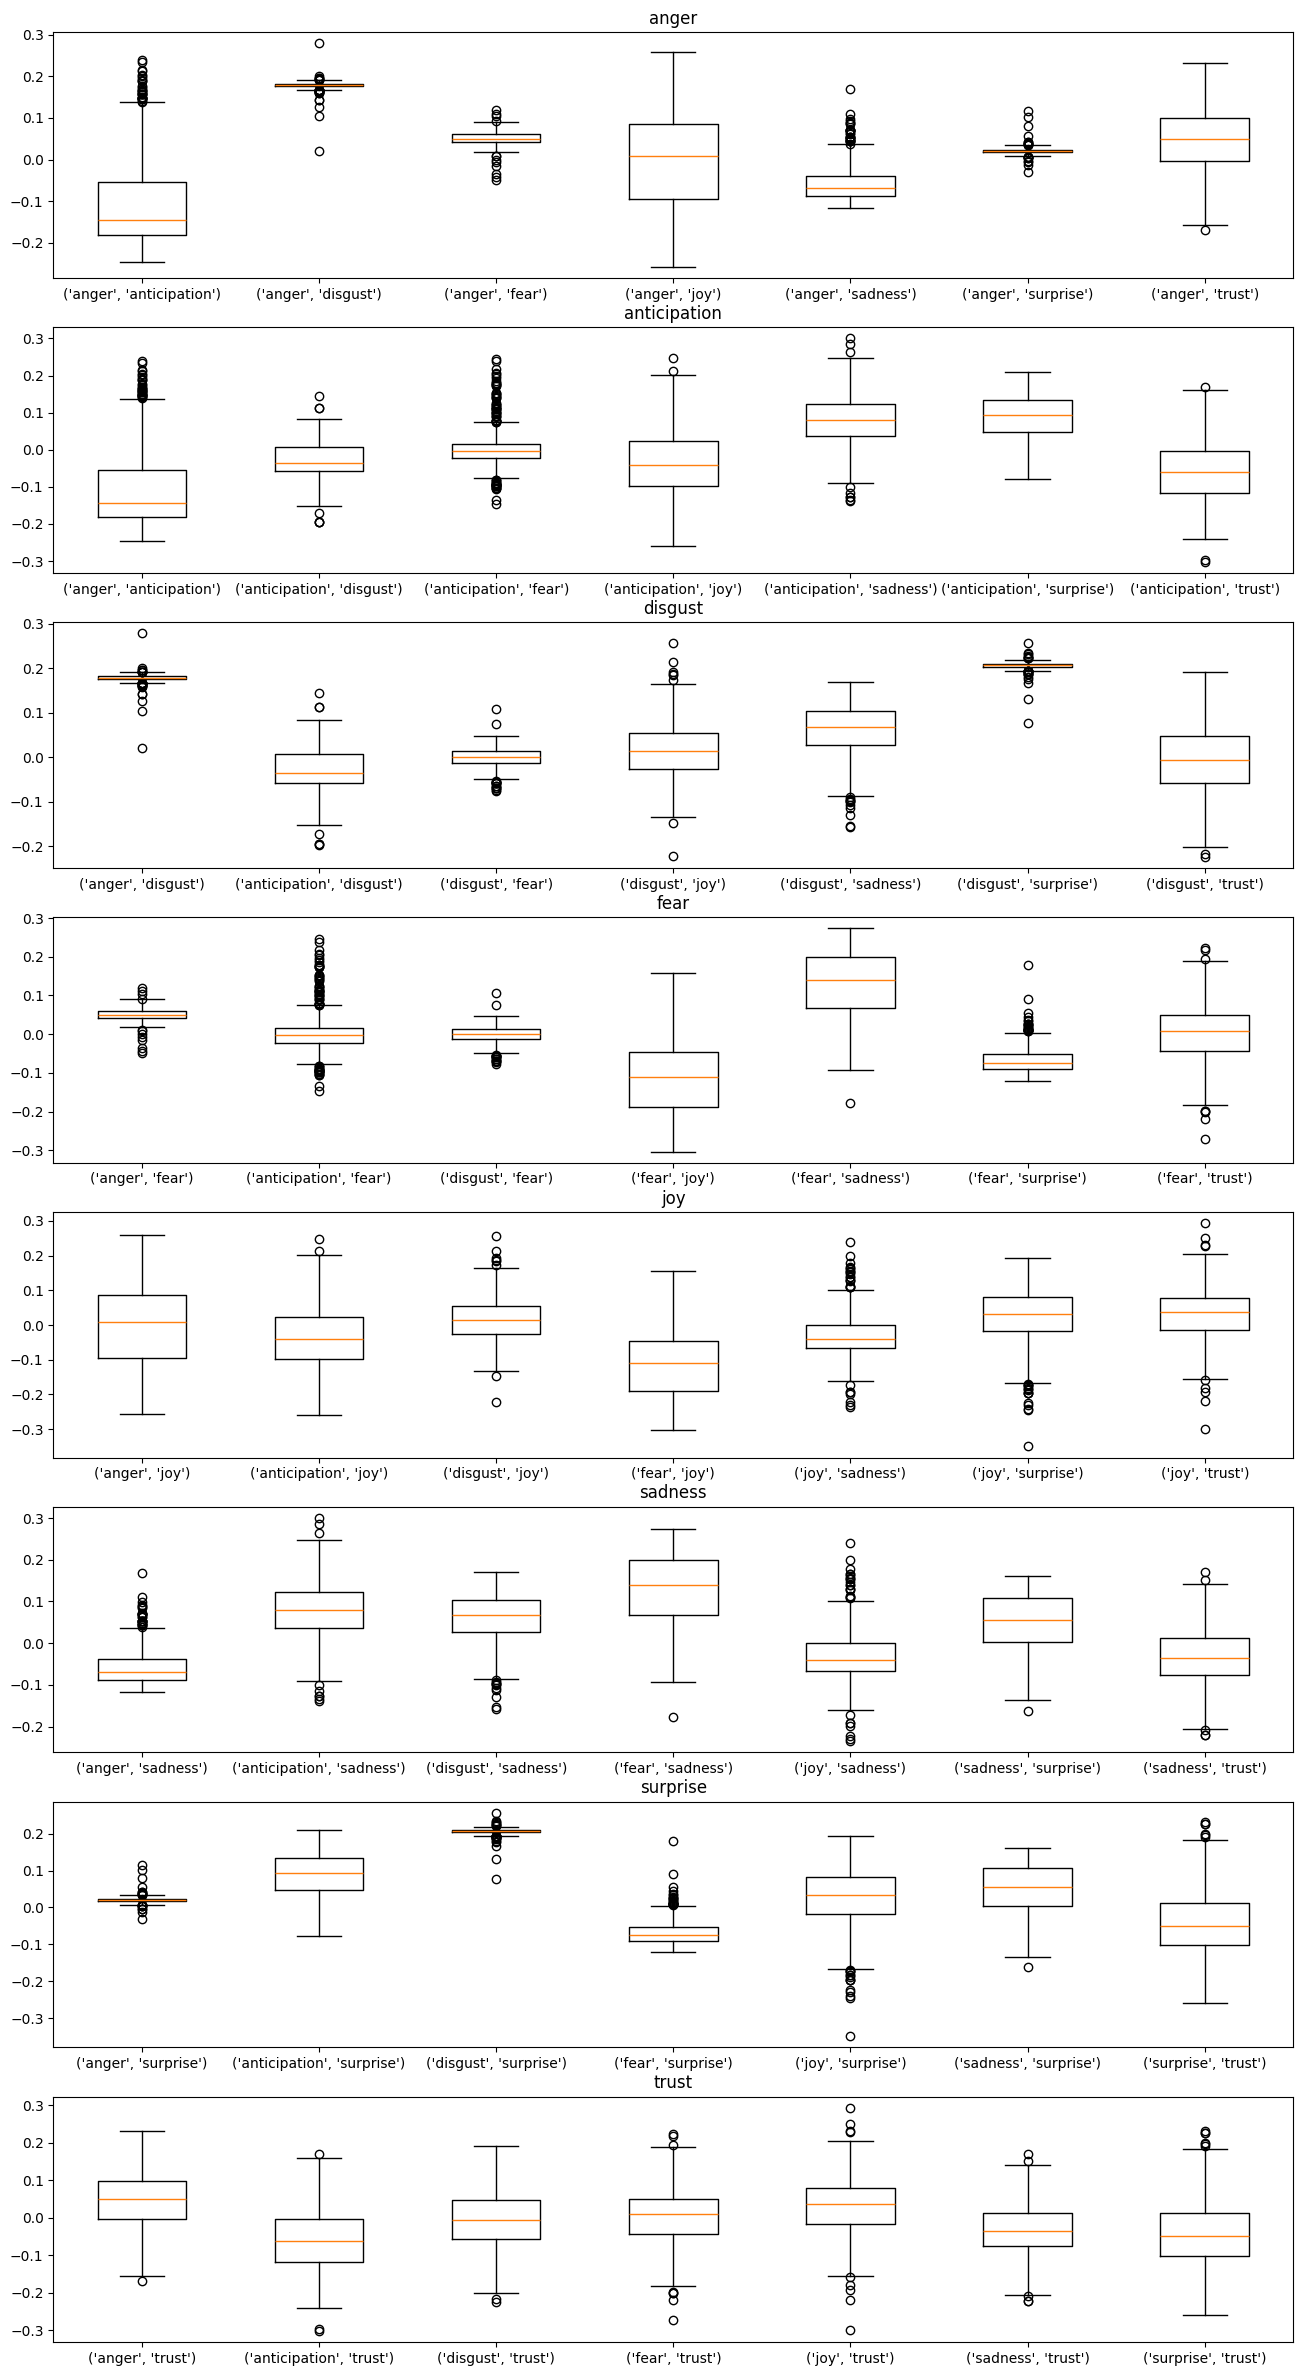

In [40]:
# Boxplots correlacion w2v modulados
import re
fig,ax = plt.subplots(8,figsize=(16,30))
columns = mod_per_emotion_info_fst.columns
i = 0
for emotion in emotion_list:
    data = []
    labels = []
    for column in columns:
        if emotion in column:
            if 'f_' in column:
                continue
            data.append([element[0] for element in mod_per_emotion_info_fst[column]])
            labels.append(re.sub(r"P_","",column))
    ax[i].boxplot(data)
    ax[i].set_xticklabels(labels)
    ax[i].set_title(emotion)
    i+=1

## Prueba de siluetas

In [59]:
#Carga datasets
df_w2v_mod = pd.read_csv("mod_embeddings_w2v.csv")
df_fst_mod = pd.read_csv("mod_embeddings_fst.csv")

display(df_w2v_mod)
display(df_fst_mod)

,N0,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N91,N92,N93,N94,N95,N96,N97,N98,N99,emotion
0,-0.042883,-0.131417,0.129601,-0.064558,0.148179,-0.030641,-0.140360,-0.084386,0.105227,0.045821,...,0.114203,-0.006689,0.089839,-0.006306,-0.022297,0.129723,-0.140863,0.147784,0.118639,anger
1,-0.048230,-0.131197,0.129147,-0.053282,0.148283,-0.030647,-0.140800,-0.085515,0.108236,0.043369,...,0.113966,-0.010303,0.085858,-0.011092,-0.021726,0.128493,-0.141854,0.148760,0.117920,anger
2,-0.047119,-0.131040,0.127404,-0.054342,0.148681,-0.038860,-0.139513,-0.081862,0.105709,0.048664,...,0.117380,-0.009764,0.087246,-0.006980,-0.024572,0.126881,-0.141445,0.148477,0.113946,anger
3,-0.045351,-0.133476,0.127025,-0.052279,0.148548,-0.027797,-0.138713,-0.083836,0.109099,0.042682,...,0.114367,-0.009167,0.089773,-0.006567,-0.022467,0.129375,-0.141669,0.149007,0.114831,anger
4,-0.044032,-0.130506,0.128314,-0.041881,0.148533,-0.031821,-0.140486,-0.082615,0.111937,0.045893,...,0.113063,-0.008090,0.087501,-0.014310,-0.014208,0.132155,-0.140144,0.149222,0.119356,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153084,-0.060425,-0.126474,0.097922,-0.087121,0.139951,-0.049202,0.067516,-0.138563,0.104225,0.137903,...,0.007875,-0.086919,-0.096425,-0.068171,-0.078243,-0.071918,-0.064585,-0.035187,-0.128850,trust
153085,-0.092625,0.100759,-0.094996,0.002993,-0.069010,0.058741,0.073680,-0.083412,0.072071,0.113492,...,0.009939,0.028048,-0.020992,-0.020416,-0.113795,-0.122120,0.129622,-0.156183,-0.043383,trust
153086,0.012939,-0.023728,0.144791,0.141896,0.113802,-0.069542,0.038184,-0.143988,0.055260,-0.108787,...,-0.145696,-0.129471,0.005603,-0.077635,0.145743,-0.076495,-0.130552,0.052770,0.142356,trust
153087,0.080628,-0.127267,-0.069144,0.077781,0.142023,-0.090171,-0.138523,-0.087010,0.138273,0.032331,...,0.103943,-0.119554,0.079625,-0.129062,-0.136483,0.116530,-0.001963,-0.040897,0.133814,trust


,N0,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N91,N92,N93,N94,N95,N96,N97,N98,N99,emotion
0,0.013877,0.058290,0.008606,-0.078425,-0.029855,0.111035,0.142159,0.137864,-0.112562,-0.116491,...,-0.102728,-0.133376,0.138357,-0.117820,0.104108,0.005247,-0.048762,0.135939,-0.080803,anger
1,0.013005,0.056545,0.014307,-0.080236,-0.032823,0.113788,0.142594,0.139070,-0.115729,-0.111897,...,-0.100311,-0.133327,0.141133,-0.115593,0.102434,0.000188,-0.048689,0.137181,-0.081448,anger
2,0.005768,0.055535,0.007227,-0.077559,-0.040145,0.115721,0.142452,0.140045,-0.116678,-0.114499,...,-0.095428,-0.132267,0.140605,-0.116344,0.103268,0.001067,-0.048531,0.138069,-0.075899,anger
3,0.010457,0.057508,0.009587,-0.076964,-0.031156,0.108005,0.142880,0.140297,-0.117494,-0.113963,...,-0.097998,-0.136347,0.141411,-0.113598,0.105203,-0.002948,-0.047653,0.137398,-0.078936,anger
4,0.007668,0.057970,0.010050,-0.074473,-0.032768,0.109237,0.142666,0.140161,-0.115436,-0.113021,...,-0.099687,-0.136130,0.141865,-0.114304,0.106825,-0.002797,-0.054824,0.137550,-0.083456,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29284,-0.065292,-0.079295,0.136772,-0.014539,0.103549,-0.037167,0.122621,-0.101878,0.133318,0.097057,...,-0.033478,-0.137804,0.138289,-0.136902,0.061042,-0.069758,-0.012791,0.133947,-0.016041,trust
29285,-0.036420,0.029866,-0.144809,-0.040907,0.081499,0.143179,0.055764,0.065843,-0.136119,-0.108039,...,-0.120222,-0.146399,0.041001,-0.109884,0.108230,-0.019370,-0.078483,0.109327,-0.000404,trust
29286,0.149957,0.047508,-0.077153,0.046774,0.021016,0.044821,0.062430,-0.024965,-0.128912,-0.141675,...,0.018140,-0.140479,0.056375,0.037125,0.009406,-0.117602,0.098962,0.130552,-0.093452,trust
29287,0.021184,0.055751,-0.118404,0.023315,0.099015,0.094141,0.082065,-0.034032,-0.129454,-0.113774,...,-0.111783,-0.151938,0.029816,-0.084273,0.087017,-0.055053,-0.034015,0.114543,-0.036197,trust


In [52]:
#Carga datasets (estos datasets fueron calculados con la notebook Clasificacion.ipynb)
df_w2v = pd.read_csv("embeddings_w2v.csv")
df_fst = pd.read_csv("embeddings_fst.csv")

columns = ["N"+str(i) for i in range(100)]
columns.append("emotion")

df_w2v.columns = columns
df_fst.columns = columns

display(df_w2v)
display(df_fst)

,N0,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N91,N92,N93,N94,N95,N96,N97,N98,N99,emotion
0,-0.076017,0.098369,-0.035965,0.054840,-0.026230,-0.217908,0.067091,0.285832,-0.090627,-0.118877,...,0.039860,-0.005281,0.014511,0.230754,0.106384,0.051394,-0.090605,0.017354,-0.018768,anger
1,-0.075675,0.098132,-0.037018,0.055113,-0.026506,-0.215662,0.065859,0.284593,-0.091683,-0.117410,...,0.041211,-0.005131,0.014910,0.231864,0.107144,0.052365,-0.090009,0.019289,-0.020563,anger
2,-0.075176,0.099532,-0.037218,0.054520,-0.026098,-0.218705,0.065259,0.285227,-0.090379,-0.119095,...,0.039926,-0.004971,0.015748,0.231975,0.106573,0.051070,-0.090186,0.017661,-0.020198,anger
3,-0.074783,0.097700,-0.036672,0.051563,-0.025413,-0.217620,0.066402,0.284785,-0.089330,-0.118217,...,0.039304,-0.004678,0.014940,0.229902,0.104336,0.049662,-0.088757,0.017867,-0.018339,anger
4,-0.076661,0.097841,-0.036690,0.053070,-0.027791,-0.217017,0.066852,0.285037,-0.091078,-0.118978,...,0.041365,-0.006535,0.014888,0.231418,0.106698,0.051201,-0.091072,0.018862,-0.020140,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153083,0.080684,0.135845,-0.046924,0.139007,-0.031085,0.039498,-0.002538,0.318500,-0.089557,-0.074771,...,0.128439,-0.029309,-0.105323,0.128416,-0.048856,-0.054254,-0.146695,0.193412,-0.102059,trust
153084,-0.088212,-0.042339,0.073892,0.166642,-0.111289,0.009717,0.162898,0.032578,-0.016663,-0.037545,...,0.007572,0.004706,-0.130327,-0.022834,0.133162,-0.068558,-0.001080,-0.109375,-0.169702,trust
153085,-0.059277,0.174416,-0.019735,-0.031871,-0.003156,-0.206303,0.006992,0.317939,-0.013038,-0.164387,...,-0.056467,-0.084445,-0.008515,0.211270,0.036823,-0.136240,-0.084599,0.063095,-0.001143,trust
153086,-0.038814,0.099347,-0.098145,0.017154,-0.026252,-0.127890,0.090131,0.287609,-0.050324,-0.121548,...,0.098052,-0.042242,0.013625,0.188535,0.175217,0.005546,-0.165326,0.089538,0.021733,trust


,N0,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N91,N92,N93,N94,N95,N96,N97,N98,N99,emotion
0,0.059186,0.039018,-0.073900,0.064061,0.041944,0.187644,-0.047828,0.189275,0.040273,-0.166675,...,-0.026101,-0.050626,0.046495,-0.055288,0.068559,-0.032620,-0.151968,0.003732,0.094632,anger
1,0.061217,0.039325,-0.075888,0.063163,0.044064,0.188553,-0.048372,0.190554,0.040730,-0.167869,...,-0.024226,-0.049824,0.045615,-0.055648,0.068222,-0.032374,-0.152015,0.004659,0.092771,anger
2,0.059904,0.038735,-0.075227,0.062948,0.041459,0.185046,-0.046734,0.190788,0.041092,-0.167586,...,-0.025179,-0.053113,0.046848,-0.054321,0.067458,-0.033497,-0.152285,0.003865,0.093766,anger
3,0.060685,0.038588,-0.075097,0.062135,0.041925,0.185592,-0.047688,0.190658,0.040118,-0.167170,...,-0.025846,-0.052954,0.047885,-0.054665,0.066767,-0.033455,-0.150130,0.004066,0.095312,anger
4,0.059405,0.039067,-0.074008,0.063049,0.042403,0.187009,-0.047146,0.190137,0.040263,-0.167577,...,-0.025504,-0.052982,0.047856,-0.054509,0.067966,-0.032904,-0.153262,0.003382,0.093903,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29283,0.082467,-0.094754,-0.021412,0.044419,-0.059212,0.036000,-0.025895,0.102657,-0.071299,-0.036085,...,-0.004739,-0.061321,0.055006,-0.086515,0.082275,-0.053785,-0.043912,0.025368,0.075015,trust
29284,0.072585,0.047321,-0.129371,0.051196,0.009845,0.200805,0.002448,0.153782,0.047512,-0.162620,...,-0.031858,-0.055588,0.000956,-0.110620,0.068529,-0.037822,-0.143992,-0.015330,0.070479,trust
29285,0.003866,0.042460,-0.099416,0.027585,0.027075,0.162879,0.000503,0.129058,0.087105,-0.179637,...,0.009854,-0.080135,0.005288,-0.153216,0.098032,-0.068496,-0.194542,-0.005824,0.097136,trust
29286,0.057304,0.040452,-0.113065,0.034124,0.004688,0.177151,-0.004925,0.126790,0.042543,-0.164007,...,-0.027528,-0.071526,-0.002248,-0.120056,0.076470,-0.047319,-0.156954,-0.014137,0.079877,trust


In [60]:
#Carga de funcion siluette score
from sklearn.metrics import silhouette_score

X_w2v = df_w2v.drop(columns=["emotion"],inplace=False)
y_w2v = df_w2v["emotion"]

X_fst = df_fst.drop(columns=["emotion"],inplace=False)
y_fst = df_fst["emotion"]

X_w2v_mod = df_w2v_mod.drop(columns=["emotion"],inplace=False)
y_w2v_mod = df_w2v_mod["emotion"]

X_fst_mod = df_fst_mod.drop(columns=["emotion"],inplace=False)
y_fst_mod = df_fst_mod["emotion"]

In [61]:
print("No moduladas w2v",silhouette_score(X_w2v,y_w2v))
print("No moduladas fst",silhouette_score(X_fst,y_fst))

print("Moduladas w2v",silhouette_score(X_w2v_mod,y_w2v_mod))
print("Moduladas fst",silhouette_score(X_fst_mod,y_fst_mod))

KeyboardInterrupt: 